# О проекте
<a id='target100'></a>

В проекте нужно:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента фитнесс-центра, 
- проанализировать признаки, наиболее сильно влияющие на отток, и предложить меры по снижению оттока,
- выделить наиболее яркие группы клиентов (в том числе, выполнить кластеризацию), найти среди них целевые группы.

В файле csv, переданном для анализа, содержатся четыре тысячи клиентских анкет с исторический информацией о выбывших (отток) и сохранённых клиентах. Оттоком считается одно из двух: либо клиент попросил закрыть договор, либо, как сказано, "за последний месяц ни разу не посетил спортзал".

### План:

1. [Ознакомление с данными (EDA)](#target1) 
2. [Кластеризация](#target2) 
3. [Обучение моделей](#target3) 
4. [Решающее дерево](#target4)
5. [Отбор признаков](#target5)
6. [Параметры случайного леса](#target6)
7. [Визуализаия ошибок](#target7)
8. [Резюме](#target99)

<a id='target1'></a>
## Ознакомление с данными (EDA)

In [1]:
!pip install plotly --upgrade
!pip install seaborn --upgrade
!pip install matplotlib --upgrade
!pip install scikit-learn==0.23.1

import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go
import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import ttest_ind, levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from collections import defaultdict
my_module_url = 'https://raw.githubusercontent.com/Artemii-Kravtsov/files/main/my_module.py'
exec(requests.get(my_module_url).text)

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


Первые 5 строк таблицы:


gender  lives_cl...  from_par...  promo_fr...  gave_his...  contract...  \
0       1            1            1            1            0            6   
1       0            1            0            0            1           12   
2       0            1            1            0            1            1   
3       0            1            1            1            1           12   
4       1            1            1            1            1            1   

   group_vi...  age  addition...  months_t...  lifetime  visit_fr...  \
0            1   29    14.227470            5         3     0.020398   
1            1   31   113.202938           12         7     1.922936   
2            0   28   129.448479            1         2     1.859098   
3            1   33    62.669863           12         2     3.205633   
4            0   26   198.362265            1         3     1.113884   

   vi_fr_re...  churn  
0     0.000000      0  
1     1.910244      0  
2     1.736502      0  
3     3.357215      0  
4     1.120078      0


Информация о таблице:


type not_null_cnt nunique     mean       min       25%  \
gender                int64         4000       2  0.51025         0         0   
lives_close           int64         4000       2  0.84525         0         1   
from_partner          int64         4000       2  0.48675         0         0   
promo_friends         int64         4000       2   0.3085         0         0   
gave_his_number       int64         4000       2   0.9035         0         1   
contract_period       int64         4000       3  4.68125         1         1   
group_visits          int64         4000       2  0.41225         0         0   
age                   int64         4000      23  29.1842        18        27   
additional_charges  float64         4000       -  146.944  0.148205   68.8688   
months_to_end         int32         4000      12  4.32275         1         1   
lifetime              int64         4000      29  3.72475         0         1   
visit_frequency     float64         4000       -  1.87902         0   1.18088   
vi_fr_recently      float64         4000       -  1.76705         0  0.963003   
churn                 int64         4000       2  0.26525         0         0   

                        50%      75%      max  
gender                    1        1        1  
lives_close               1        1        1  
from_partner              0        1        1  
promo_friends             0        1        1  
gave_his_number           1        1        1  
contract_period           1        6       12  
group_visits              0        1        1  
age                      29       31       41  
additional_charges   136.22   210.95  552.591  
months_to_end             1        6       12  
lifetime                  3        5       31  
visit_frequency     1.83277  2.53608  6.02367  
vi_fr_recently      1.71957  2.51034  6.14678  
churn                     0        1        1

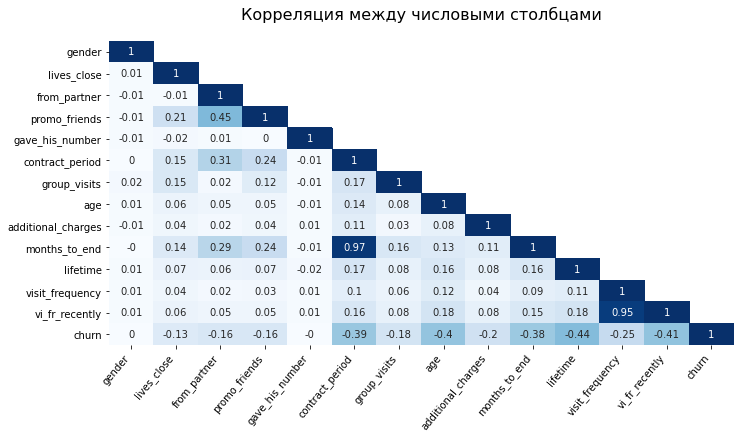

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv').rename({'Near_Location': 'lives_close', 'Partner': 'from_partner', 
                                            'Phone': 'gave_his_number', 'Month_to_end_contract': 'months_to_end', 
                                            'Avg_additional_charges_total': 'additional_charges', 
                                            'Avg_class_frequency_total': 'visit_frequency', 
                                            'Avg_class_frequency_current_month': 'vi_fr_recently'}, axis = 1)
df['months_to_end'] = df['months_to_end'].astype('int')
df.columns = df.columns.str.lower()
print('Первые 5 строк таблицы:')
display(df.head().rename(columns = lambda x: ''.join([x[:8], '...']) if len(x) > 9 else x))
print('\nИнформация о таблице:')
display(my_info(df))
print()
corr_matrix(df, half_table = True)

Переменная 'churn' содержит два значения: единицу, если в текущем месяце клиент не посещал спортзал, и ноль, если посещал. С переменной, названной в оригинале 'Avg_class_frequency_current_month' не так всё ясно. Судя по названию (а именно, по словам 'current_month'), речь тоже про текущий месяц, но в описания датасета (оно было предоставлено вместе с датасетом) говорится, что переменная содержит среднюю частоту посещений за предыдущий месяц. Чтобы внести ясность, посмотрим на распределение 'Avg_class_frequency_current_month' у тех клиентов, которые "выбыли" в текущем месяце.

In [3]:
my_display(df[ df.churn == 1 ]['vi_fr_recently'].describe())

vi_fr_recently
count     1061.000000
mean         1.044546
std          0.770237
min          0.000000
25%          0.421337
50%          0.979445
75%          1.588576
max          3.540271

Во-первых, переменная в самом деле описывает предыдущий месяц, иначе она не принимала бы никакое значение, кроме нуля (ведь из значения 'churn' следует, в текущем месяце эти посетители выбыли). Пусть так, но тогда настораживает, что минимальное значение, принимаемое переменной, равно нулю. Это говорит о том, что клиенты не посещали спортзал не только в этом месяце, но и в предыдущем. А значит, факт оттока для них нужно было зафиксировать месяцем раньше. Но это тоже противоречит описанию датасета, где говорится, что мы располагаем "данными за месяц до оттока и фактом оттока на определённый месяц". 

Посмотрим на историю клиентов, которые не посещали спортзал не только в текущем месяце, но и в предыдущем.

In [4]:
display(df[ (df.churn == 1) & (df.vi_fr_recently == 0) ][['contract_period', 'months_to_end', 
                                                          'lifetime', 'visit_frequency']].describe())

contract_period  months_to_end    lifetime  visit_frequency
count       134.000000     134.000000  134.000000       134.000000
mean          1.805970       1.783582    1.000000         0.500324
std           2.212329       2.174223    1.256562         0.391137
min           1.000000       1.000000    0.000000         0.000000
25%           1.000000       1.000000    0.000000         0.161144
50%           1.000000       1.000000    1.000000         0.450680
75%           1.000000       1.000000    1.000000         0.765916
max          12.000000      12.000000    9.000000         1.513746

Таких всего 134 человека, 0.3% от всего объёма данных. Больше трёх четвертей из них владеют месячными абонементами, у такой же доли с момента их привлечения (переменная 'lifetime') прошёл месяц. Притом есть такие, которые вообще ни разу не воспользовались абонементом. Но в общей массе картина по этим клиентам сопоставима с общей картиной, вполне адекватна. 

Невозможно, чтобы при 'lifetime', равном 1, 'vi_fr_recently' был нулевым, а 'visit_frequency' отличался от нуля. Если есть записи, для которых это верно, их можно без раздумий удалить.

In [5]:
was = df.shape[0]
df.drop(df[ (df.churn == 1) & (df.vi_fr_recently == 0) & (df.visit_frequency != 0) & (df.lifetime == 1)].index,
        inplace = True)
print(f'Удалено {was - df.shape[0]} записей')

Удалено 48 записей


Невозможно, чтобы 'visit_frequency' был нулевым, в то время как 'vi_fr_recently' ненулевым. Если такие записи есть, их тоже можно сразу удалить.

In [6]:
was = df.shape[0]
df.drop(df[ (df.vi_fr_recently != 0) & (df.visit_frequency == 0) ].index, inplace = True)
print(f'Удалено {was - df.shape[0]} записей')

Удалено 29 записей


Также логично предположить, что если кто-то является клиентом компании на протяжении всего лишь одного месяца, то его 'vi_fr_recently' и 'visit_frequency' должны совпадать.

In [7]:
temp = df[ df['lifetime'] == 1 ]
display(temp[ temp['vi_fr_recently'] == temp['visit_frequency'] ][['contract_period', 
                                                                   'visit_frequency', 'churn']].describe())

contract_period  visit_frequency      churn
count        12.000000             12.0  12.000000
mean          4.166667              0.0   0.416667
std           4.932883              0.0   0.514929
min           1.000000              0.0   0.000000
25%           1.000000              0.0   0.000000
50%           1.000000              0.0   0.000000
75%           7.500000              0.0   1.000000
max          12.000000              0.0   1.000000

Но таких записей, что странно, нет. Те двенадцать клиентов, которых мы нашли - это те, кто ни посещал спортзал ни разу. Интереснее всего, что лишь пятерых из них считают выбывшими, у остальных в поле 'churn' стоит ноль. Такого, пожалуй, быть не может. 

In [8]:
df.drop(temp[ (temp['vi_fr_recently'] == temp['visit_frequency']) & (temp.churn == 0) ].index, inplace = True)

Почему на предыдущем шаге мы не нашли совпадающих 'visit_frequency' и 'vi_fr_recently' при 'lifetime', равном 1? Скорее всего, 'lifetime' == 1 означает, что со времени появления клиента прошёл один полный месяц и один неполный. Если это предположение верно, тогда значения не совпадают по той причине, что в поле 'visit_frequency' содержатся данные, полученные за всё время, тогда как в поле 'vi_fr_recently' - либо данные по итогам предыдущего календарного месяца, либо данные за предыдущие тридцать дней.

Напрашивается создание нового поля, в котором была бы записана разница между средними посещениями за всё время и за предыдущий месяц. Назовём его 'trend'.
- разница должна быть относительной, потому что нужно поймать снижение интереса к посещению спортзала и выразить его в общей для всех посетителей мере.
- держим в уме сделанные только что выводы о том, что у клиентов с 'lifetime' == 1 особая ситуация. Есть два варианта. Либо у них данные в поле 'vi_fr_recently' являются устаревшими по сравнению с данными в поле 'visit_frequency' (когда в них записаны средние посещения за предыдущий календарный месяц), либо в этом поле данные за последние тридцать дней, и тогда они, наоборот, более свежие. Посчитаем новое поле дважды, чтобы проверить, в каком случае признак будет лучше отражать реальное положение дел. 

Относительное изменение можно посчитать посредством деления. Одно замечание: мы нашли 134 человека (сейчас уже меньше), которые за предыдущий месяц не были в спортзале ни разу (и несколько тех, кто ни был вообще никогда). Но если мы будем делить что-либо на ноль, то получим ноль или ошибку. Чтобы этого избежать, заменим все нули на 0.00001.

trend_pct
count  3916.000000
mean     -0.073676
std       0.302482
min      -0.999993
25%      -0.091482
50%      -0.010959
75%       0.028608
max       6.244537

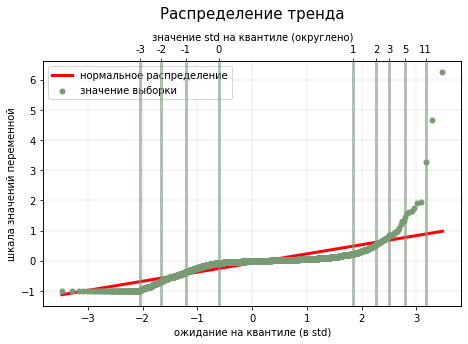

In [9]:
df.loc[ df['vi_fr_recently'] == 0, 'vi_fr_recently'] = 0.00001
df.loc[ df['visit_frequency'] == 0, 'visit_frequency'] = 0.00001
df['trend_pct'] = df['vi_fr_recently'].div(df['visit_frequency']) - 1
df['trend_pct_calendar'] = df.apply(lambda row: row['trend_pct'] if row.lifetime != 1 
                                     else (row['visit_frequency'] / row['vi_fr_recently']) - 1, axis = 1)
my_display(df['trend_pct'].describe())
qq_plot(df['trend_pct'], title = 'Распределение тренда', real_SE = [-3, -2, -1, 0, 1, 2, 3, 5, 10])

Видим три выброса. Их можно удалить. И сразу проверим, какая из двух интерпретаций лучше предсказывает отток, ведь убывающие средние посещения, само собой, должны увеличивать вероятность того, что клиент перестанет посещать спортзал.

In [10]:
df = df[df['trend_pct'] < 2]
churn_rate_first = df[ df['trend_pct'] < 0 ]['churn'].mean()
churn_rate_second = df[ df['trend_pct_calendar'] < 0 ]['churn'].mean()
print('1ый способ: доля выбывших среди тех, кто стал реже посещать спортзал: {:.1%}'.format(churn_rate_first))
print('2ой способ: доля выбывших среди тех, кто стал реже посещать спортзал: {:.1%}'.format(churn_rate_second))

1ый способ: доля выбывших среди тех, кто стал реже посещать спортзал: 37.1%
2ой способ: доля выбывших среди тех, кто стал реже посещать спортзал: 29.9%


Если считать, что в поле 'vi_fr_recently' записаны данные за предыдущий календарный месяц (и делать соответствующие поправки при расчёте тренда), то по значениям в этом поле становится значительно тяжелее предсказывать отток посетителей, чем в том случае, когда мы предполагаем, что значения в этом поле подсчитываются за последние тридцать дней. 

In [11]:
df.drop('trend_pct_calendar', axis = 1, inplace = True)

Клиент, 'lifetime' которого совпадает со сроком, на который куплен абонемент - это клиент, который впервые покупает абонемент. Таких посетителей будет полезно пометить.

In [12]:
df['first_time_client'] = (df.contract_period == df.lifetime).astype('int')

Часто человек, который покупает годовой абонемент (найдём таких по переменной 'contract_period'), не бросит заниматься после первого месяца. А вот переменная 'time_to_end' вряд ли будет столь же полезна - у одного клиента может быть 11 месяцев "в запасе", у другого ноль, при этом оба только начинают заниматься по своему абонементу (значение в этом поле приобретает смысл только в паре со значением 'contract_period'). Будет лучше посчитать, сколько месяцев после покупки абонемента клиент уже отзанимался. Возможно, это будет не линейная зависимость с оттоком, но пользу такой признак всё-равно может принести.

In [13]:
df['elapsed_time'] = df.contract_period.sub(df.months_to_end).astype('int')

In [14]:
temp = pd.DataFrame()
bin_vars = ['gender', 'lives_close', 'from_partner', 'promo_friends', 'gave_his_number', 
             'group_visits', 'first_time_client']
for col in bin_vars:
    temp_col = df.groupby(col).agg({'churn': 'mean', 'age': 'count'}).reset_index().rename({col: 'value'}, axis = 1)
    temp_col['column'] = col
    temp = temp.append(temp_col)
temp = temp.sort_values(by = ['column', 'value'])
traces_list = []
for val, name, color in zip([1, 0], ['Да', 'Нет'], ['#424642', '#c06014']):
    temp_sl = temp[ temp.value == val ]
    traces_list.append(go.Bar(x = temp_sl['column'].values, y = temp_sl['churn'].values, 
                              name = name, marker = {'color': color}, orientation = 'v', 
                              text = [f'Значений «{val}» («{name}»): {cnt} строк' for cnt in temp_sl['age'].values],
                              hovertemplate = "Поле <b>'%{x}'</b><br>%{text}<br>Отток: %{y:.1%}<extra></extra>"))
layout = dict(template = 'ggplot2', height = 400, width = 700, 
              yaxis = dict(tickformat = '%{x}:.1%'), 
              title = dict(font_size = 16, y = 0.92,
              text = '<b>Отток в зависимости от значения булевых переменных:</b>', x = 0.5, yanchor = 'top',  
              xanchor = 'center', xref = 'paper'), margin = dict(l = 0, r = 0, t = 100, b = 20), legend = dict(
              font_size = 14, orientation = 'h', yanchor = 'top', y = 1.2, xanchor = 'center', x = 0.5, 
                  title = '<b>Значение:</b><br>', font = {'size': 40}))
fig = go.Figure(data = traces_list, layout = layout)
fig.add_hline(y = df.churn.mean(), annotation_text = 'Средний отток', annotation = {'font_size': 14}, 
              annotation_position = 'bottom right', line_width = 7)
fig.show(config = my_plotly_config(display_bar = False))

- Клиентов, которые покупают не первый свой абонемент ('first_time_client'), примерно в шесть раз больше, чем новых, и отток среди них заметно ниже по сравнению с теми, кто покупает первый. Это сильный признак.
- Если клиент получил корпоративную скидку на абонемент ('from_partner'), то он будет посещать спортзал с большей вероятностью, чем тот, кто этой скидки не получил. Любопытно, что соотношение корпоративных и не-корпоративных клиентов в спортзале - почти один к одному. Это необычно. Корпоративных клиентов много, и они относительно редко выбывают. Почему? Возможно, благодаря тому, что в одном зале с ними тренируются их коллеги (судя по графику 'promo_friends', это такой фактор, который снижает вероятность оттока). Проверим:

In [15]:
my_display(df[ df.from_partner == 1 ]['promo_friends'].value_counts(normalize = True)
           .apply(lambda x: '{:.1%}'.format(x)).rename({1: "пришли по акции 'приведи друга'", 0: 'остальные'}), 
           index_name = "корпоративные клиенты:", col_names = [''])
my_display(df[ df.promo_friends == 1  ]['from_partner'].value_counts(normalize = True)
            .apply(lambda x: '{:.1%}'.format(x)).rename({1: "корпоративные клиенты", 0: 'остальные'}), 
           index_name = "пришли по акции 'приведи друга':", col_names = [''])

корпоративные клиенты:                
пришли по акции 'приведи друга'  52.3%
остальные                        47.7%

пришли по акции 'приведи друга':       
корпоративные клиенты             82.6%
остальные                         17.4%

... похоже, что так. Посмотрим, останется ли у корпоративных клиентов низкая вероятность оттока в том случае, если мы учтём только тех, кто НЕ воспользовался акцией "приведи друга". Если показатели оттока выровняются, значит, для предсказания оттока это поле не нужно - будет достаточно 'promo_friends'.

In [16]:
print('Отток клиентов, купивших абонемент без промо-кода от друга:')
my_display(df[ (df.promo_friends == 0) ].groupby('from_partner')['churn'].mean()
           .apply(lambda x: '{:.1%}'.format(x)).rename({1: "корпоративные клиенты", 0: 'остальные'}), 
           col_names = ['churn_rate'])

Отток клиентов, купивших абонемент без промо-кода от друга:


churn_rate
остальные                  33.7%
корпоративные клиенты      24.6%

Разница сохранилась, но теперь она не такая значительная, какой казалась до этого. Это говорит нам о том, что при обучении модели можно будет поэкспериментировать с включением переменной 'from_partner' в обучающую выборку. В самом деле, поля 'promo_friends' может оказаться достаточно.

Продолжим интерпретировать график:

- Определённо, пол клиента ('gender') и то, оставил ли он свой номер телефона ('gave_his_number') не влияет на вероятность оттока.
- Посетители, которые ходят на групповые занятия ('group_visits'), выбывают реже тех, кто тренируется самостоятельно.
- Проживание вдалеке от спортзала ('lives_close') - фактор, негативно влияющий на вероятность оттока. Примерно 15% от всех клиентов живут далеко, и отток среди них выше среднего. 
- Клиенты, которые пришли в спортзал по приглашению друга, выбывают реже тех, кто пришёл сам (переменная 'promo_friends'). У них в зале есть партнёры или, по меньшей мере, единомышленники. Поэтому нет ничего удивительного в том, что поле может быть значимым при предсказании оттока.

Нужно убедиться, что в реальных данных интерпретируемые нами различия сохранятся, и, значит, можно обучать модели, чувствительные к этим различиям.

In [17]:
print('Тест на равенство долей оттока:')
print('{: >40}'.format('z-статистика'), '{: >30}'.format('p_value'), '{: >45}'.format('Нулевая гипотеза (a = 0.05)'), 
      sep = '', end = '\n')
for col in bin_vars:
    values = df.groupby(col)['churn'].value_counts()
    a_successes, b_successes, a_trials, b_trials = (values[1][1], values[0][1], 
                                                    values[1][0] + values[1][1], values[0][0] + values[0][1])
    stat, pval = proportions_ztest([a_successes, b_successes], [a_trials, b_trials])
    h0 = 'Отклонить' if pval < 0.05 else 'Принять'
    print('{: <25}{: <32}{: <39}{}'.format(col, abs(stat), pval, h0))

Тест на равенство долей оттока:
                            z-статистика                       p_value                  Нулевая гипотеза (a = 0.05)
gender                   0.14205821659045592             0.8870340217150738                     Принять
lives_close              7.960174291853946               1.7179711029546712e-15                 Отклонить
from_partner             9.888077753919532               4.6894566838696995e-23                 Отклонить
promo_friends            10.322642900638133              5.5669308439636915e-25                 Отклонить
gave_his_number          0.25360183948019027             0.799803175384073                      Принять
group_visits             10.703237644975207              9.828295260773006e-27                  Отклонить
first_time_client        18.23149428171137               2.9028031248771115e-74                 Отклонить


Так и есть, притом различия существенные (кроме полей 'gender' и 'gave_his_number').

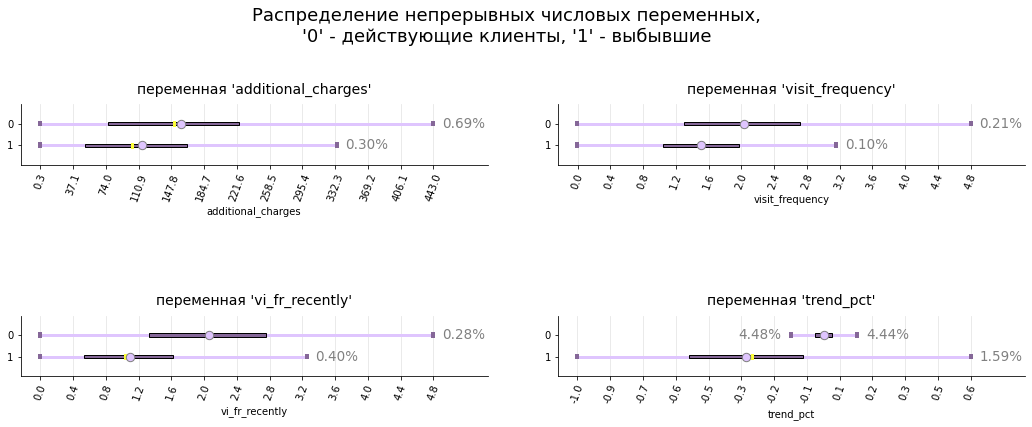

In [18]:
fig = plt.figure(figsize = (18, 5))
fig.suptitle("Распределение непрерывных числовых переменных,\n'0' - действующие клиенты, '1' - выбывшие", 
             fontsize = 18, y = 1.15)
grid = fig.add_gridspec(2, 2, wspace = 0.15, hspace = 2.5)
fig.add_subplot(grid[0, 0]); fig.add_subplot(grid[0, 1])
fig.add_subplot(grid[1, 0]); fig.add_subplot(grid[1, 1])
cont_vars = ['additional_charges', 'visit_frequency', 'vi_fr_recently', 'trend_pct']
for ax, col in zip(fig.axes, cont_vars):
    boxplot_sequence(df, 'churn', col, ax = ax)
    ax.set_title(f"переменная '{col}'", y = 1.08, fontsize = 14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
display(fig)
plt.close(fig)

- По дополнительным расходам ('additional_charges') можно судить о том, насколько возможен отток. Чем меньше расходов, тем будет больше вероятность оттока. Но распределения сильно пересекаются, поэтому у этого признака при построении модели вряд ли будет большой вес.
- Поскольку из двух переменных, обозначающих частоту посещений, нужно выбрать одну, лучше выбрать частоту посещений за последний месяц - у выбывших клиентов распределение этой переменной меньше пересекается с её распределением у удержанных клиентов.   
- Относительное изменение частоты посещений за последнее время ('trend_pct') - в его распределении можно увидеть интересный момент. Казалось, что у выбывших клиентов интерес к занятию спортом должен постепенно угасать, и для 75% из них это действительно, однако примерно четверть из выбывших за прошлый месяц стали тренироваться чаще, чем до этого, притом значительно чаще. И выбыли, может быть, оттого, что не освоились с такой нагрузкой, какую возложили на себя. В противоположность им, дисперсия этой же переменной у удержанных клиентов очень невелика - они по большей части не стали за последнее время заниматься ни больше, но и не меньше, чем в среднем (хотя стоит обратить внимание на 4.5% выбросов как с одной, так и с другой стороны).

Есть мысль, что по модулю 'trend_pct' можно более эффективно предсказать отток - ведь мы увидели, что не только резкое уменьшение частоты посещений грозит оттоком, но и резкое увеличение. 

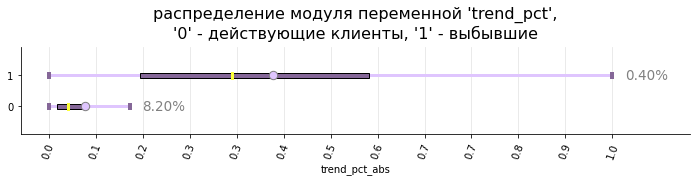

Корреляция 'trend_pct' с оттоком: -0.51
Корреляция модуля 'trend_pct' с оттоком: 0.62


In [19]:
cont_vars.append('trend_pct_abs')
df['trend_pct_abs'] = df['trend_pct'].abs()
boxplot_sequence(df, 'churn', 'trend_pct_abs', 
                 title = "распределение модуля переменной 'trend_pct',\n'0' - действующие клиенты, '1' - выбывшие")
print("Корреляция 'trend_pct' с оттоком:", df['trend_pct'].corr(df['churn']).round(2))
print("Корреляция модуля 'trend_pct' с оттоком:", df['trend_pct_abs'].corr(df['churn']).round(2))

Да, так гораздо лучше. Признак сильный, правда его трудно назвать так, чтобы было понятно: "модуль относительного изменения частоты посещений". Мы рассмотрели пять непрерывных числовых перенных. В первых трёх случаях мы считаем, что у групп отличаются выборочные средние, в четвёртом и пятом - что отличается дисперсия.

In [20]:
print('Тест на равенство выборочных средних:')
print('{: >40}'.format('cтатистика'), '{: >30}'.format('p_value'), '{: >45}'.format('Нулевая гипотеза (a = 0.05)'), 
      sep = '', end = '\n')
for i, col in enumerate(cont_vars):
    if i >= 3:
        test = levene
        if i == 3:
            print('\nТест Левена на равенство дисперсий:')
    else: 
        test = ttest_ind
    a = df[ df.churn == 1 ][col]
    b = df.drop(a.index)[col]
    stat, pval = test(a, b)
    h0 = 'Отклонить' if pval < 0.05 else 'Принять'
    print('{: <25}{: <32}{: <39}{}'.format(col, abs(stat), pval, h0))

Тест на равенство выборочных средних:
                              cтатистика                       p_value                  Нулевая гипотеза (a = 0.05)
additional_charges       12.616063843951775              8.501173421022358e-36                  Отклонить
visit_frequency          15.605672431095309              2.6169730991484895e-53                 Отклонить
vi_fr_recently           27.67839686121324               3.790333214378664e-154                 Отклонить

Тест Левена на равенство дисперсий:
trend_pct                1488.3228290968768              3.2706270169849697e-276                Отклонить
trend_pct_abs            1381.8773430963126              2.73222809570375e-259                  Отклонить


Теперь, когда мы создали переменную, которая отражает то, насколько сильно изменилась частота посещений за последнее время (не важно, в какую сторону), встаёт вопрос о том, не нужно ли нам дополнительно создать булеву переменную, в которой всё-таки пометить, если это изменение резко отрицательное. Для начала нужно опредеделиться с тем, насколько резким должно быть уменьшение, которое мы хотим зафиксировать. 

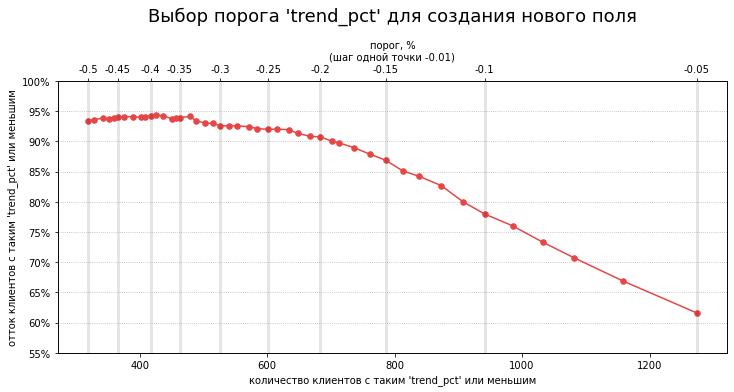

In [21]:
choosing_thr = {}
for thr in np.arange(-0.5, -0.04, 0.01):
    thr_info = df.groupby((df.trend_pct <= thr).astype('int')).agg({'churn': 'mean','age': 'count'}).loc[1, :]
    choosing_thr.update({thr: [thr_info['churn'], thr_info['age']]})
choosing_thr = pd.DataFrame(choosing_thr).T

fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(choosing_thr.iloc[:, 1], choosing_thr.iloc[:, 0], marker = 'o', ms = 5.5, color = '#e84545')
ax.grid(b = True, axis = 'y', color = 'k', linestyle = 'dotted', alpha = 0.3)
ax_grid = ax.twiny()
ax_grid.tick_params(bottom = False, labelbottom = False, top = True, labeltop = True)
ax_grid.xaxis.set_label_position('top')
ax_grid.grid(b = True, axis = 'x', linewidth = 3, color = 'k', alpha = 0.1, ds = 'steps-pre')
ax_grid.set_xlim(ax.get_xlim())
ax_grid.set_xlabel("порог, %\n(шаг одной точки -0.01)")
ax.set_xlabel("количество клиентов c таким 'trend_pct' или меньшим")
ax.set_ylabel("отток клиентов c таким 'trend_pct' или меньшим")
ax.set_title("Выбор порога 'trend_pct' для создания нового поля", y = 1.2, fontsize = 18)
ax.set(yticks = ax.get_yticks(), yticklabels = ['{:.0%}'.format(tick) for tick in ax.get_yticks()])
xticks_pos = [ choosing_thr.loc[thr][1] for i, thr in enumerate(choosing_thr.index, 5) if (i % 5 == 0) ]
xticks_lab = [ round(thr, 2) for i, thr in enumerate(choosing_thr.index, 5) if (i % 5 == 0) ]
ax_grid.set_xticks(xticks_pos)
ax_grid.set_xticklabels([f"{str(xt)}" for xt in xticks_lab])
display(fig)
plt.close(fig)

Порог в -15% вполне подходит. У клиентов, которые за последние 30 дней стали посещать спортзал на 15% реже (или ещё реже), сохраняется высокий уровень оттока (около 87% - это немногим меньше, чем максимальные 95%), при этом их уже довольно много (одна пятая от всех клиентов). Дальше с каждым шагом прибавляется всё больше клиентов, но и средний отток среди них начинает стремительно падать.

In [22]:
df['15%_vi_fr_decrease'] = (df.trend_pct <= -0.15).astype('int')
df['vi_fr_decrease'] = (df.trend_pct < 0).astype('int')

Надо заметить, что даже при незначительном уменьшении средней частоты посещений уровень оттока остаётся высоким (значительно выше медианы). Имеет смысл попробовать два признака - 15%-ое уменьшение посещаемости и любое уменьшение - и сравнить эффективность моделей. Чего делать точно не стоит - использовать 15%-ое уменьшение одновременно с модулем изменения частоты, потому что это будут две переменные с большим весом, описывающие одно явление. 

Рассмотрим распределение дискретных переменных.

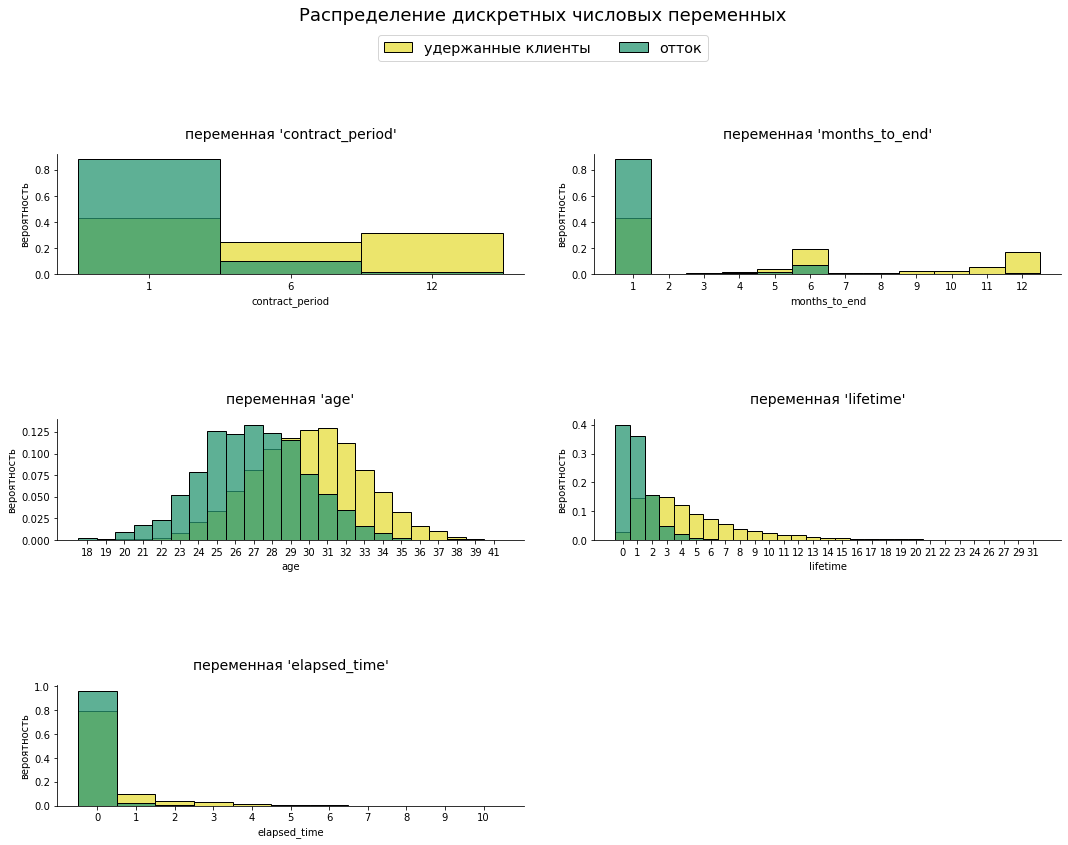

In [23]:
fig = plt.figure(figsize = (18, 12))
fig.suptitle("Распределение дискретных числовых переменных", 
             fontsize = 18, y = 1.05)
grid = fig.add_gridspec(3, 2, wspace = 0.15, hspace = 1.2)
fig.add_subplot(grid[0, 0]); fig.add_subplot(grid[0, 1])
fig.add_subplot(grid[1, 0]); fig.add_subplot(grid[1, 1])
fig.add_subplot(grid[2, 0])

categorical_cols = ['contract_period', 'months_to_end', 'age', 'lifetime', 'elapsed_time']
slice_churn = df[ df.churn == 1]
slice_stay = df[ df.churn == 0]

for col, ax in zip(categorical_cols, fig.axes):
    mapper = {}
    reverse_mapper = {}
    for i, x in enumerate(np.sort(df[col].unique()), 1):
        mapper.update({x: i})
        reverse_mapper.update({i: x})
    churn_temp = slice_churn[col].copy().map(mapper)
    stay_temp = slice_stay[col].copy().map(mapper)
    if col == categorical_cols[0]:
        labels = ['удержанные клиенты', 'отток']
    else:
        labels = [None, None]
    sns.histplot(data = stay_temp.reset_index(), x = col, stat = 'probability', label = labels[0],
                 discrete = True, color = '#e6dd3b', ax = ax)
    sns.histplot(data = churn_temp.reset_index(), x = col, stat = 'probability', label = labels[1],
                 discrete = True, color = '#289672', ax = ax)
    ax.set(xticks = list(mapper.values()), xticklabels = [reverse_mapper[val] for val in mapper.values()],
           ylabel = 'вероятность')
    ax.set_title(f"переменная '{col}'", y = 1.08, fontsize = 14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
fig.legend(loc = 'upper center', ncol = 2, fontsize = 'x-large', bbox_to_anchor = (0.5, 1.025))
display(fig)
plt.close(fig)

Все рассмотренные переменные могут быть полезны, кроме 'months_to_end', которая по сути повторяет то, что более наглядно видно на распределении 'contract_period' (срок действия абонемента). Особого внимания заслуживает переменная 'lifetime', судя по которой, большая часть оттока приходится на клиентов, пришедших в спортзал совсем недавно.

Вот так в конечном итоге выглядит таблица:

In [24]:
df = df.drop(['gender', 'gave_his_number', 'months_to_end', 'visit_frequency'], axis = 1)
df = downcast_convertion(df)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3913 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lives_close         3913 non-null   uint8  
 1   from_partner        3913 non-null   uint8  
 2   promo_friends       3913 non-null   uint8  
 3   contract_period     3913 non-null   uint8  
 4   group_visits        3913 non-null   uint8  
 5   age                 3913 non-null   uint8  
 6   additional_charges  3913 non-null   float32
 7   lifetime            3913 non-null   uint8  
 8   vi_fr_recently      3913 non-null   float32
 9   churn               3913 non-null   uint8  
 10  trend_pct           3913 non-null   float32
 11  first_time_client   3913 non-null   int32  
 12  elapsed_time        3913 non-null   int32  
 13  trend_pct_abs       3913 non-null   float32
 14  15%_vi_fr_decrease  3913 non-null   int32  
 15  vi_fr_decrease      3913 non-null   int32  
dtypes: flo

None

<a id='target2'></a>
## Кластеризация
[// вернуться к началу](#target100) 

Кластеризация и регрессия чувствительны к шкалированию данных. Стандартизируем значения переменных, отделим целевую переменную от признаков.

In [25]:
df_zs = df.copy()
for col in df.drop('churn', axis = 1).columns:
    df_zs[col] = st.zscore(df[col])
X = df_zs.drop('churn', axis = 1)
y = df_zs['churn']

С помощью иерархической агломеративной кластеризации можно визуализировать расстояние между кластерами и увидеть, в каких границах лежит оптимальное количество кластеров.

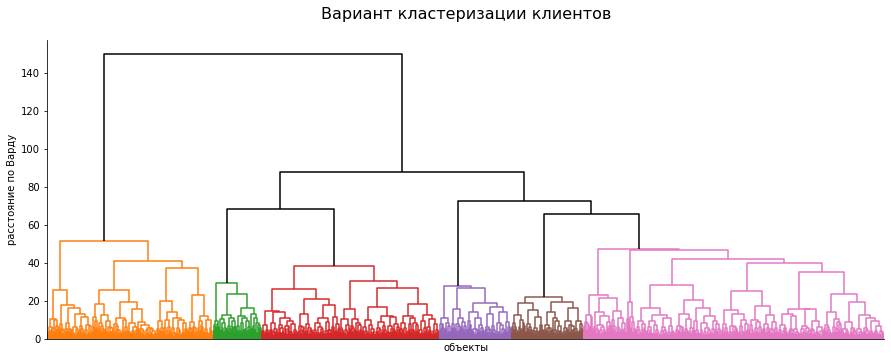

In [26]:
linked = linkage(X, method = 'ward')
fig, ax = plt.subplots(figsize = (15, 5.5))
ax.set_title('Вариант кластеризации клиентов', fontsize = 16, y = 1.05)
ax.set(ylabel = 'расстояние по Варду', xlabel = 'объекты')
dendrogram(linked, orientation = 'top', no_labels = True, color_threshold = 60, 
           ax = ax, above_threshold_color = 'black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
display(fig)
plt.close(fig)

Смотря как посмотреть, - от трёх до девяти. Выделение шести кластеров (выделены цветом) выглядит оптимальным. Попробуем все варианты (используя метод KMeans), для каждого замерим метрику silhouette.

In [27]:
for i in np.arange(3, 10):
    km = KMeans(n_clusters = i, random_state = 0)
    print(f'{i} кластеров, silhouette =', round(silhouette_score(X, km.fit_predict(X)), 4))

3 кластеров, silhouette = 0.1544
4 кластеров, silhouette = 0.1567
5 кластеров, silhouette = 0.1605
6 кластеров, silhouette = 0.1619
7 кластеров, silhouette = 0.1552
8 кластеров, silhouette = 0.1534
9 кластеров, silhouette = 0.1414


Шесть кластеров - самое лучшее. Стоит отметить, что во всех случаях silhouette низкое - кластеризация не очень естественно ложится на полный набор признаков. Тем ни менее, у нас есть шесть кластеров - посмотрим, в чём их отличия.

In [28]:
km = KMeans(n_clusters = 6, random_state = 0)
df['cluster'] = km.fit_predict(X)
cnt_cl = df['cluster'].value_counts()
cnt_cl.name = 'clients_cnt'
print('Один столбец - средние значения переменных в одном кластере')
display(df.groupby('cluster').mean().applymap(lambda x: round(x, 2)).T.append(cnt_cl))

Один столбец - средние значения переменных в одном кластере


0       1       2       3       4       5
lives_close            1.00    0.77    1.00    0.82    0.00    0.94
from_partner           0.20    0.38    0.93    0.38    0.53    0.68
promo_friends          0.06    0.20    0.83    0.20    0.09    0.37
contract_period        3.53    2.02    8.27    1.68    3.88   11.31
group_visits           0.42    0.30    0.52    0.39    0.24    0.60
age                   29.71   27.18   29.89   29.01   29.57   29.96
additional_charges   153.45  116.97  160.61  143.19  148.95  159.63
lifetime               4.73    1.33    4.61    1.68    4.27    4.79
vi_fr_recently         2.07    0.74    2.03    1.93    2.01    2.21
churn                  0.10    0.90    0.03    0.39    0.14    0.02
trend_pct              0.02   -0.51    0.02    0.03    0.03    0.01
first_time_client      0.00    0.25    0.01    1.00    0.01    0.01
elapsed_time           0.09    0.07    0.32    0.06    0.12    4.10
trend_pct_abs          0.06    0.51    0.06    0.10    0.07    0.06
15%_vi_fr_decrease     0.00    1.00    0.01    0.07    0.02    0.04
vi_fr_decrease         0.46    1.00    0.47    0.50    0.45    0.43
clients_cnt         1288.00  727.00  961.00  353.00  368.00  216.00

- 90% оттока в 1ом кластере. 1ый кластер, третий по численности, составлен из клиентов, которых отличает резкое падение в частоте посещений за последний месяц (у каждого не менше чем на 15%, в среднем - на 51%). Так же это в среднем самая молодая группа, у них самые низкие 'lifetime' и дополнительные расходы ('addtitional_charges').
- почти 40% оттока у клиентов из третьего кластера. Их всех отличает то, что они купили свой первый абонемент в фитнес-клуб (по большей мере, месячный), у них тоже невысокий средний 'lifetime', зато за последний месяц они не стали ходить на тренировки реже или чаще. 

Столбец с кластером - первая категориальная переменная в данных. Для модели логистической регрессии будет лучше, если этот столбец разложить на dummy-переменные. В пайплайне, если эта затея оправдает себя, для поступающих наблюдений нужно будет сначала предсказывать кластер, и только затем отток.

In [29]:
df_zs['cluster'] = df['cluster']
df_zs = pd.get_dummies(df_zs, columns = ['cluster'])
for col in df_zs.iloc[:, -6:].columns:
    df_zs[col] = st.zscore(df_zs[col])

<a id='target3'></a> 
## Обучение моделей
[// вернуться к началу](#target100) 

Разделим данные на обучающую и тестовую выборки.

In [30]:
X = df_zs.drop(['churn'], axis = 1)
y = df_zs['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Напишем функцию, которая поможет в обучении и диагностике моделей на разных выборках и с разными параметрами.

In [31]:
def make_prediction(model, X_test, y_test, return_metrics = False):
    y_pred = model.predict(X_test)
    probablities = model.predict_proba(X_test)[:,1]
    ((tn, fp), (fn, tp)) = confusion_matrix(y_test, y_pred)
    if not return_metrics:
        print('{: >30}{}\n{: >30}{:.3f}\n{: >30}{:.3f}\n{: >30}{:.3f}\n{: >30}{:.4f}\n'.format(
                      'Матрица ошибок: ', f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}',
                      'Точность (precision): ', precision_score(y_test, y_pred),
                      'Полнота: ', recall_score(y_test, y_pred),
                      'F1: ', f1_score(y_test, y_pred),
                      'ROC_AUC: ', roc_auc_score(y_test, probablities)))
    else:
        return {'Матрица ошибок': f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}',
                'Точность (precision)': precision_score(y_test, y_pred),
                'Полнота': recall_score(y_test, y_pred),
                'F1': f1_score(y_test, y_pred),
                'ROC_AUC': roc_auc_score(y_test, probablities)}

def learn(X, y, models = None, return_models = False, return_metrics = False, print_metrics = True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    
    if not models:
        models_given = False
        all_metrics = {}
        models = [LogisticRegression(random_state = 0, C = 1),
                  DecisionTreeClassifier(random_state = 0, min_samples_leaf = 125),
                  RandomForestClassifier(random_state = 0)]
        for model, title in zip(models, ['Логистическая регрессия', 'Решающее дерево', 
                                         'Ансамбль случайных деревьев']):
            model.fit(X_train, y_train)
            if return_metrics:
                all_metrics.update({title: make_prediction(model, X_test, y_test, True)})
            elif print_metrics:
                print(title)
                make_prediction(model, X_test, y_test)
                
        if return_metrics:
            return all_metrics
            
    else:
        models_given = True
        if len(models.items()) == 1 and return_metrics:
            list(models.values())[0].fit(X_train, y_train)
            return make_prediction(list(models.values())[0], X_test, y_test, True)
        elif return_metrics:
            all_metrics = {}
            for title, model in models.items():
                model.fit(X_train, y_train)
                all_metrics.update({title: make_prediction(model, X_test, y_test, True)})
            return all_metrics
        else:
            for title, model in models.items():
                model.fit(X_train, y_train)
                if print_metrics:
                    print(title)
                    make_prediction(model, X_test, y_test)
    
    if return_models and models_given:
        return list(models.values())
    elif return_models:
        return models

При подготовке кода для решающего дерева удалось подобрать параметр, отвечающий за минимальное количество объектов в ветви, при котором вырастает полнота и ROC_AUC, но падает точность. На дефолтном дереве полнота - 0.78, ROC_AUC - 0.87, на "подрезанном" полнота - 0.85, ROC_AUC - 0.95. Задать этот параметр в любом случае следовало, поскольку в обучающей выборке не так много наблюдений, при том что много признаков. 

Для линейной регрессии наиболее подходящим коэффициентом регуляризации (параметр C) оказалось '1' - то же самое, что по умолчанию.

Обучим три модели: логистическую регрессию, решающее дерево и случайных лес.

In [32]:
lin, tree, forest = learn(X, y, return_models = True)

Логистическая регрессия
              Матрица ошибок: TN: 563, FP: 15, FN: 37, TP: 168
        Точность (precision): 0.918
                     Полнота: 0.820
                          F1: 0.866
                     ROC_AUC: 0.9797

Решающее дерево
              Матрица ошибок: TN: 529, FP: 49, FN: 30, TP: 175
        Точность (precision): 0.781
                     Полнота: 0.854
                          F1: 0.816
                     ROC_AUC: 0.9470

Ансамбль случайных деревьев
              Матрица ошибок: TN: 566, FP: 12, FN: 37, TP: 168
        Точность (precision): 0.933
                     Полнота: 0.820
                          F1: 0.873
                     ROC_AUC: 0.9842



Выходит, что вероятность оттока лежит на поверхности - даже ненастроенные модели отлично справляются с предсказаниями. Обращает на себя внимание, что оценка вероятности оттока во всех четырёх моделях ближе к действительности (ROC_AUC: от 0.95 до 0.98), чем сама классификация (остальные метрики). Это может означать, что можно будет построить ROC-кривую и подобрать порог для классификации самостоятельно. 

Для компании приоритетной метрикой является полнота, то есть способность угадать как можно больше клиентов, которые в скором времени уйдут в отток (минимизация False Negative). Если при этом повысится доля ошибок False Positive (и упадёт метрика точности), то это не так страшно: ваимодействие с клиентом не станет хуже, если мы будем предполагать (ошибочно), что он в скором времени уйдёт. 

<a id='target4'></a> 
## Решающее дерево
[// вернуться к началу](#target100) 

Посмотрим, как отработало "подрезанное" дерево:

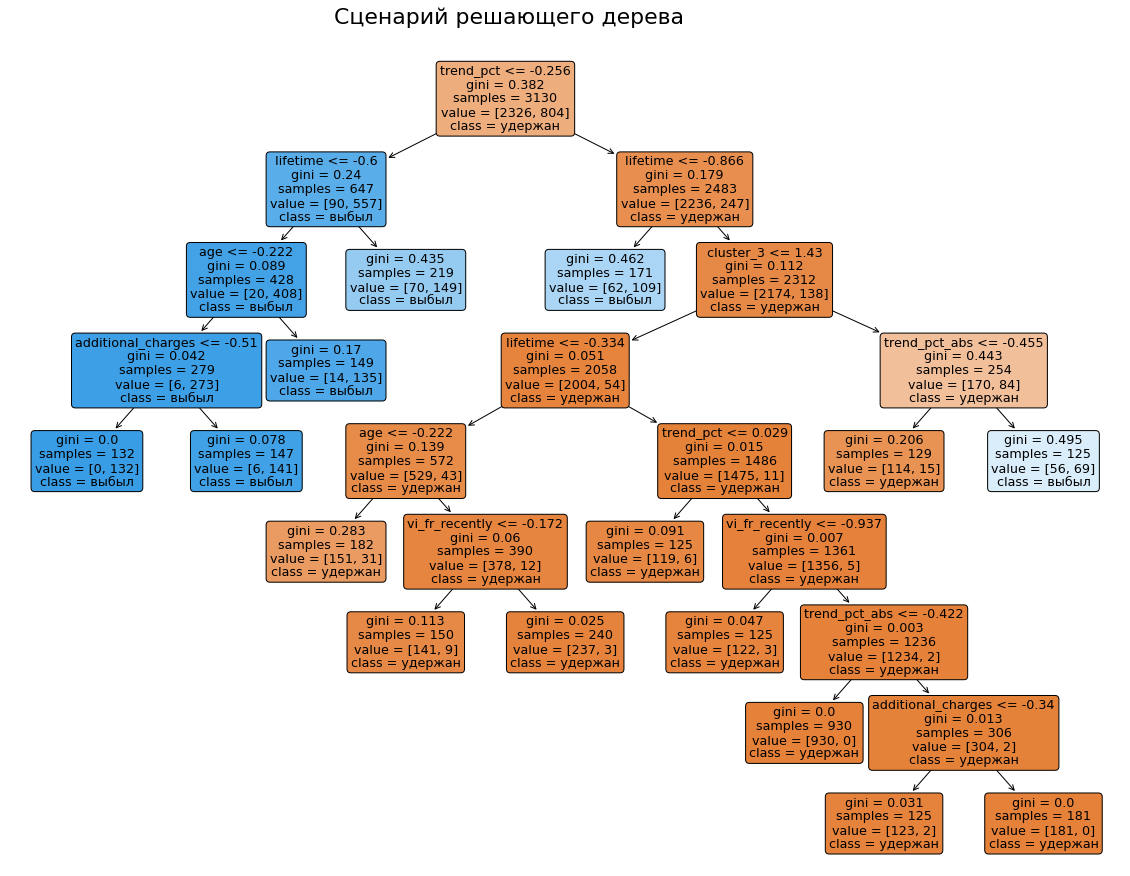

In [33]:
fig, ax = plt.subplots(figsize = (20, 15))
plot_tree(tree, filled = True, feature_names = X_train.columns, class_names = ['удержан', 'выбыл'], 
          rounded = True, fontsize = 12.7, ax = ax)
ax.set_title('Сценарий решающего дерева', fontsize = 22, y = 1.03, x = 0.45)
display(fig)
plt.close(fig)

Пяти ветвлений оказалось достаточно, чтобы принять решение (то есть при max_depth = 5 предсказания бы не поменялись). Дальнейшие ветвления ведут к уточнению вероятностей, но не меняют классификацию. Более того, оценка поля 'trend_pct' - это практически benchmark, то есть такое решение, которого достаточно, чтобы c неплохим результатом предсказать отток, не прибегая к машинному обучению. 

In [34]:
y_pred = (X_test.trend_pct <= -0.256).astype('int')
((tn, fp), (fn, tp)) = confusion_matrix(y_test, y_pred)
print("Классифицируем по значению 'trend_pct'")
print('Отток предсказываем для тех наблюдений, у которых после стандартизации значение меньше -0.256\n')
print('{: >30}{}\n{: >30}{:.3f}\n{: >30}{:.3f}\n{: >30}{:.3f}'.format(
              'Матрица ошибок: ', f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}',
              'Точность (precision): ', precision_score(y_test, y_pred),
              'Полнота: ', recall_score(y_test, y_pred),
              'F1: ', f1_score(y_test, y_pred)))

Классифицируем по значению 'trend_pct'
Отток предсказываем для тех наблюдений, у которых после стандартизации значение меньше -0.256

              Матрица ошибок: TN: 564, FP: 14, FN: 75, TP: 130
        Точность (precision): 0.903
                     Полнота: 0.634
                          F1: 0.745


Дерево оказалось лучше бенчмарка, потому что провело ещё три сравнения:
1. Если тренд больше -0.256, но низкий 'lifetime', то предсказывается отток.
2. Если 'lifetime' высокий, но клиент принадлежит 3му кластеру и имеет высокий модуль тренда, то предсказывается отток.
3. Для остальных наблюдений предсказывается удержание.

Разумеется, это не единственно возможный сценарий, но тот, который наиболее оптимален на случайных выборках. Если изменим 'random_state', изменится и сценарий дерева.

In [35]:
probabilities = tree.predict_proba(X_test)[:, 1]
draw_roc(y_test, probabilities, mode_05 = 'hide', title = 'Решающее дерево: ROC-кривая')

Немногочисленные ветвления ведут к листам, которых всего... 

In [36]:
print(f'{np.unique(probabilities).shape[0]} уникальных вероятностей')

14 уникальных вероятностей


14 сценарных исходов. Поэтому на ROC-кривой так мало точек - 14. Конечно, это не самый гибкий и не самый мощный способ машинного обучения, но в этом случае он отлично сочетает эффективность (TPR = 0.85 при FPR = 0.085) и простоту  (администратор фитнесс-клуба может в уме рассчитать вероятность оттока, пока здоровается с клиентом).

<a id='target5'></a> 
## Отбор признаков
[// вернуться к началу](#target100) 

Делая разведывательный анализ, мы опасались мультиколлинеарности признаков. А некоторые признаки, может быть, оказались излишними и лишь создают шум. Сейчас, когда мы имеем обученные предсказательные модели, это можно проверить с помощью функции `permutation_importance` библиотеки sklearn.inspection. Функция десять раз перемешивает случайным образом значения каждого признака в той выборке, которая поступает обученной модели для предсказания. Важностью признака после перемешивания ('permutation_importance') называется то, как сильно в среднем за эти десять раз упало значение целевой метрики (целевой метрикой мы укажем полноту). 

Этот способ позволяет диагностировать наличие скоррелированных признаков для модели, показывающей хорошие результаты. Если важность скоррелированных призаков после перемешивания мала, значит, стоит перемешать один - и тогда хватает веса другого, скореллированного с этим, признака, чтобы сделать похожие предсказания и не сильно просесть в целевой метрике. 

Можно диагностировать переобученность: если признак оказывается важен на обучающей выборке, но не важен на валидационной, значит, модель переобучена по этому признаку. Или, например, вводят в обучающую выборку переменную - генератор случайных чисел. Если важность этой переменной на обучающей выборке больше нуля, значит, модель переобучилась. 

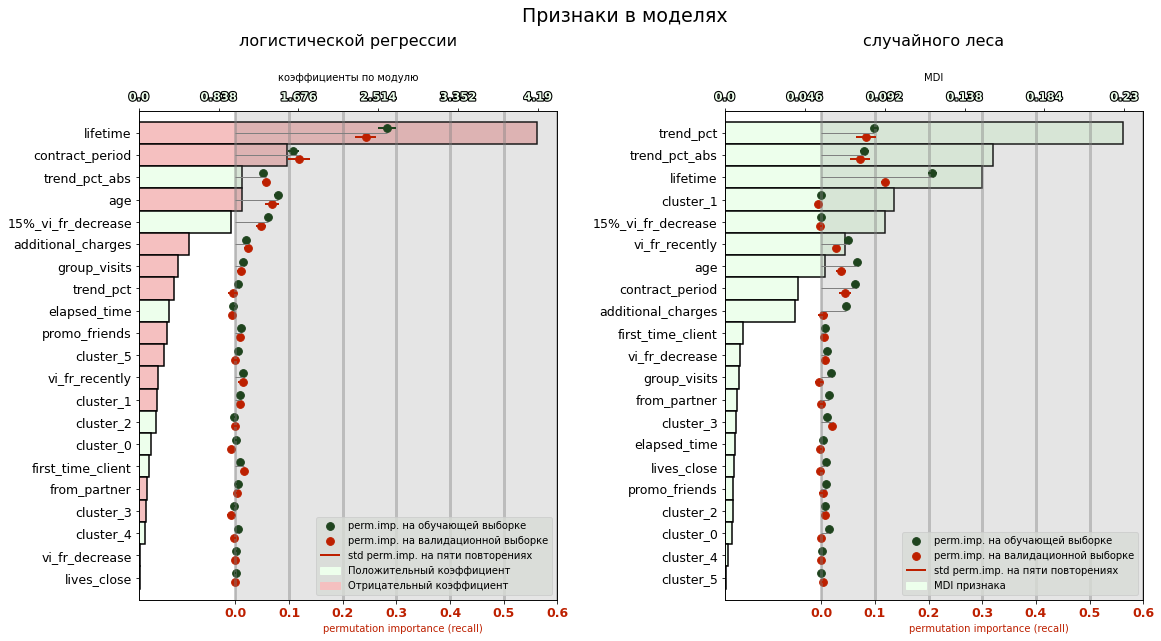

In [37]:
fig = plt.figure(figsize = (18, 9))
fig.suptitle('Признаки в моделях', fontsize = 19, y = 1.04)
grid = fig.add_gridspec(1, 2, wspace = 0.4)
ax1 = fig.add_subplot(grid[0, 0]); ax2 = fig.add_subplot(grid[0, 1])
features_importance(lin, 'linear', 'логистичеcкой регрессии', X, y, scoring = 'recall', ax = ax1)
features_importance(forest, 'forest', 'случайного леса', X, y, scoring = 'recall', ax = ax2)
display(fig)
plt.close(fig)

Помимо 'permutation_importance', на графике логистической регрессии нарисованы коэффициенты признаков, а на графике случайного леса - важность признаков ('MDI' - суммарное уменьшение загрязнения Джини во всех ветвлениях, использующих этот параметр для разделения).

**Логистическая регрессия**. Оказались не важны практически все признаки, у которых коэффициент по модулю меньше 0.4. В некоторых случаях для выборки с перемешанными значениями модель даже давала лучшие предсказания, чем для выборки с оригинальными значениями.

**Случайный лес**. Несмотря на то, что такие признаки как 'cluster_1', '15%_vi_fr_decrease' оценены как важные, их влияние на полноту равно нулю. Влияние 'trend_pct' и 'trend_pct_abs' на полноту относительно ниже, чем их MDI. Избыточные мультиколлинеарные признаки могут не вредить функционалу случайного леса, но однозначно вредят возможности интерпретировать работу модели, и, что хуже, производят ненужные ветвления, чем ограничивают возможность оптимизировать работу леса с помощью специальных параметров. Ещё есть впечатление, что по тем признакам, которые оказались важны ('lifetime', 'age', 'contract_period'), лес переобучился. 

Сейчас займёмся скоррелированными признаками. Корреляцию можно рассматривать как расстояние по Варду, тогда 1 будет наименьшим расстоянием, и скоррелированные признаки можно объединять в кластеры. 

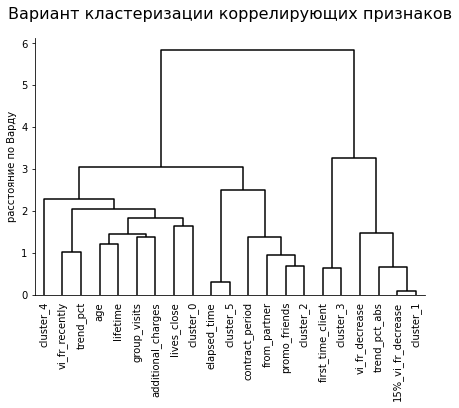

In [38]:
corr_clusters(X, 0, title = 'Вариант кластеризации коррелирующих признаков');

Возникает два вопроса:
1. ниже какого порога должно быть расстояние между А и B, чтобы объединить их в один кластер?
2. если A и B отнесены к одному кластеру, значит, мы считаем их мультиколлинеарными. Который из них удалить?

Сделаем так:
1. попробуем разные пороги, от нуля (изначальный вариант, кластеров ровно столько, сколько признаков) до 2.5 (выше не имеет смысла - так у нас не останется ни одного признака). 
2. сделаем две выборки: из одной, для регрессии, будем удалять признаки с меньшими коэффициентами. Из другой, для леса, будем удалять признаки с меньшей важностью (MDI). 

In [39]:
def remove_correlated_features(model, model_type, X, thr_max):
    actual_features = set(X.columns)
    if model_type == 'linear':
        coeffs = np.abs(model.coef_[0])
    elif model_type == 'forest':
        coeffs = model.feature_importances_
    for thr in np.arange(0, thr_max, 0.1):
        clusters = corr_clusters(X, thr, draw_dendrogram = False)
        clusters['coeffs'] = clusters.index.map(dict(zip(X.columns, coeffs)))
        new_cols = set(clusters[ clusters.coeffs.isin(clusters.groupby('cluster')['coeffs'].max()) ].index)
        removed_cols = actual_features.difference(new_cols)
        if len(removed_cols) == 0 and thr != 0:
            continue
        actual_features = new_cols
        X_exp = X.loc[:, actual_features]
        metrics = learn(X_exp, y, models = {0: model}, return_metrics = True)
        print('{: <45}'.format(', '.join(list(removed_cols)) + [':' if thr != 0 else '<изначальный вариант>'][0]), 
              end = '')
        print(metrics['Матрица ошибок'], '. ROC_AUC: ', round(metrics['ROC_AUC'], 4), sep = '')
        
print('Если из обучающей выборки для логистической регрессии последовательно удалять признаки: \n')
remove_correlated_features(lin, 'linear', X, 2.5)

Если из обучающей выборки для логистической регрессии последовательно удалять признаки: 

<изначальный вариант>                        TN: 563, FP: 15, FN: 37, TP: 168. ROC_AUC: 0.9797
cluster_1:                                   TN: 563, FP: 15, FN: 38, TP: 167. ROC_AUC: 0.9796
cluster_5:                                   TN: 564, FP: 14, FN: 37, TP: 168. ROC_AUC: 0.9799
cluster_3, cluster_2, 15%_vi_fr_decrease:    TN: 563, FP: 15, FN: 36, TP: 169. ROC_AUC: 0.9783
from_partner:                                TN: 563, FP: 15, FN: 40, TP: 165. ROC_AUC: 0.9783
vi_fr_recently:                              TN: 562, FP: 16, FN: 38, TP: 167. ROC_AUC: 0.9782
age:                                         TN: 559, FP: 19, FN: 44, TP: 161. ROC_AUC: 0.9697
group_visits, promo_friends:                 TN: 564, FP: 14, FN: 50, TP: 155. ROC_AUC: 0.968
vi_fr_decrease, additional_charges:          TN: 564, FP: 14, FN: 53, TP: 152. ROC_AUC: 0.9653
lives_close:                                 TN: 564, FP

In [40]:
print('Если из обучающей выборки для случайного леса последовательно удалять признаки: \n')
remove_correlated_features(forest, 'forest', X, 2.5)

Если из обучающей выборки для случайного леса последовательно удалять признаки: 

<изначальный вариант>                        TN: 566, FP: 12, FN: 40, TP: 165. ROC_AUC: 0.9822
15%_vi_fr_decrease:                          TN: 568, FP: 10, FN: 40, TP: 165. ROC_AUC: 0.9799
cluster_5:                                   TN: 570, FP: 8, FN: 41, TP: 164. ROC_AUC: 0.9826
cluster_3, cluster_2, cluster_1:             TN: 568, FP: 10, FN: 37, TP: 168. ROC_AUC: 0.9832
promo_friends:                               TN: 569, FP: 9, FN: 37, TP: 168. ROC_AUC: 0.9826
vi_fr_recently:                              TN: 563, FP: 15, FN: 47, TP: 158. ROC_AUC: 0.9766
age:                                         TN: 560, FP: 18, FN: 45, TP: 160. ROC_AUC: 0.9641
from_partner, group_visits:                  TN: 560, FP: 18, FN: 56, TP: 149. ROC_AUC: 0.961
vi_fr_decrease, additional_charges:          TN: 557, FP: 21, FN: 58, TP: 147. ROC_AUC: 0.9481
cluster_0:                                   TN: 558, FP: 20, FN: 

Дополнительно удалим 'trend_pct' из обеих выборок, так как знаем, что он компенсируется полем 'trend_pct_abs'. Между столбцами не линейная корреляция, поэтому они не объединяются в один кластер.

In [58]:
to_remove_lin = ['cluster_1', 'cluster_5', 'cluster_2', 'cluster_3',
                 'from_partner', 'churn', 'trend_pct']
to_remove_forest = ['15%_vi_fr_decrease', 'cluster_5', 'cluster_1', 'cluster_2', 'cluster_3', 
                    'promo_friends', 'churn', 'trend_pct']

X_lin = df_zs.drop(to_remove_lin, axis = 1)
X_for = df_zs.drop(to_remove_forest, axis = 1)

Посмотрим, как теперь будут справляться модели.

Логистическая регрессия на новой выборке:
              Матрица ошибок: TN: 564, FP: 14, FN: 38, TP: 167
        Точность (precision): 0.923
                     Полнота: 0.815
                          F1: 0.865
                     ROC_AUC: 0.9797

Случайный лес на новой выборке:
              Матрица ошибок: TN: 566, FP: 12, FN: 38, TP: 167
        Точность (precision): 0.933
                     Полнота: 0.815
                          F1: 0.870
                     ROC_AUC: 0.9823



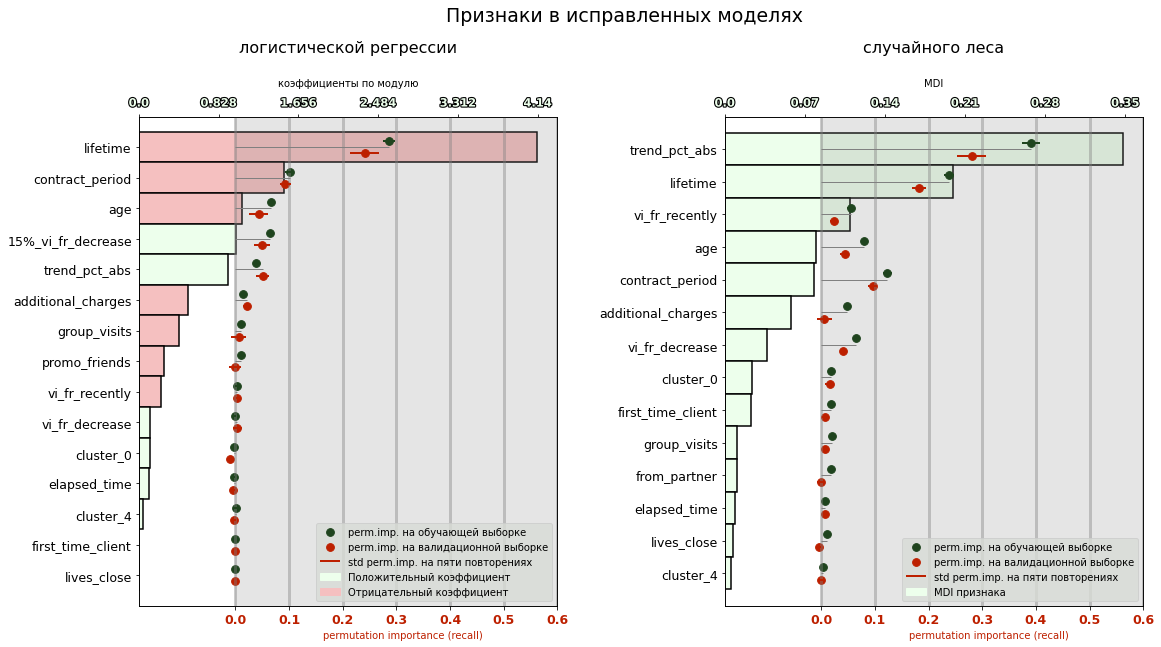

In [59]:
lin_mod = learn(X_lin, y, models = {'Логистическая регрессия на новой выборке:': 
                LogisticRegression(random_state = 0, C = 1)}, return_models = True)[0]
forest_mod = learn(X_for, y, models = {'Случайный лес на новой выборке:': 
                   RandomForestClassifier(random_state = 0)}, return_models = True)[0]

fig = plt.figure(figsize = (18, 9))
fig.suptitle('Признаки в исправленных моделях', fontsize = 19, y = 1.05)
grid = fig.add_gridspec(1, 2, wspace = 0.4)
ax1 = fig.add_subplot(grid[0, 0]); ax2 = fig.add_subplot(grid[0, 1])
features_importance(lin_mod, 'linear', 'логистичеcкой регрессии', X_lin, y, scoring = 'recall', ax = ax1)
features_importance(forest_mod, 'forest', 'случайного леса', X_for, y, scoring = 'recall', ax = ax2)
display(fig)
plt.close(fig)

Обе модели стали хуже на одно ложноотрицательное предсказание по сравнению с первоначальным вариантом. Лес ухудшился на две тысячных AUC_ROC, логистическая регрессия слегка поднялась по F1. При этом мы удалили по шесть - семь признаков из выборок. Логистическая регрессия на этом моменте готова.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_lin, y, test_size = 0.2, random_state = 0)
probabilities = lin_mod.predict_proba(X_test)[:, 1]
draw_roc(y_test, probabilities, mode_05 = 'explain', title = 'Логистическая регрессия: ROC-кривая')

По ROC-кривой видно: если при вероятности оттока большей или равной 0.2011 мы будем предсказывать отток, то будем угадывать 94-95 из 100 клиентов, которые в скором времени перестанут посещать спортзал. Примерно 17-18 из 100 из таких предсказаний будут ошибочными ($\frac{FP}{TP + FP}$, или $1 - точность$) - в этих случаях не случится оттока там, где мы его предсказали.

<a id='target6'></a> 
## Параметры случайного леса
[// вернуться к началу](#target100) 

Судя по 'permutation_importnace', что лес с дефолтными настройками явно переобучился. Чтобы убедиться, получим предсказания леса для обучающей выборки.

In [44]:
X_train2, _, y_train2, _ = train_test_split(X_for, y, test_size = 0.2, random_state = 0)
make_prediction(forest_mod, X_train2, y_train2)

              Матрица ошибок: TN: 2326, FP: 0, FN: 0, TP: 804
        Точность (precision): 1.000
                     Полнота: 1.000
                          F1: 1.000
                     ROC_AUC: 1.0000



Так и есть. Поборемся с переобученностью леса. Есть несколько параметров, настройка которых может решить проблему переобученности. Но чтобы их ввести, нужно понимать, в какой области значений они могут лежать. Получим несколько характеристик о переобученном лесе.

Средняя глубина дерева: 15.87



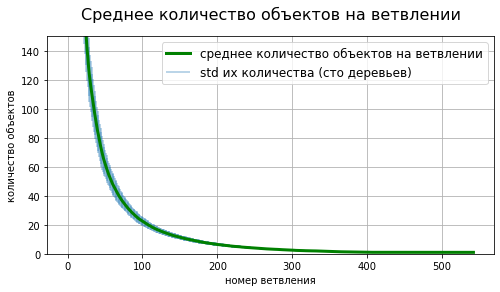

In [45]:
depths = []
for i in range(100):
    depths.append(forest_mod.estimators_[i].tree_.max_depth)
print('Средняя глубина дерева:', np.mean(depths), end = '\n\n')

samples_per_node = defaultdict(list)
means = []
stds = []
for i in range(100):
    tree_structure = forest_mod.estimators_[i].tree_
    samples = []
    for o in range(tree_structure.node_count):
        samples.append(tree_structure.n_node_samples[o])
    for i, o in enumerate(sorted(samples)[::-1]):
        samples_per_node[i].append(o)
    
xticks = np.arange(0, len(samples_per_node))
for i in xticks:
    means.append(np.mean(samples_per_node[i]))
    stds.append(np.std(samples_per_node[i]))
    
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(xticks, means, color = 'green', label = 'среднее количество объектов на ветвлении', linewidth = 3)
ax.set_title('Cреднее количество объектов на ветвлении', fontsize = 16, y = 1.05)
ax.set(ylim = (0, 150), xlabel = 'номер ветвления', ylabel = 'количество объектов')
ax.vlines(x = xticks, ymin = np.array(means) - np.array(stds), ymax = np.array(means) + np.array(stds), 
          label = 'std их количества (сто деревьев)', alpha = 0.4)
ax.legend(fontsize = 'large')
ax.grid(b = True, axis = 'both')
display(fig)
plt.close(fig)

Теперь можно подготовить список из таких параметров, которые могут оказаться оптимальными. Функция `RandomizedSearchCV` из библиотеки sklearn.model_selection делает кросс-валидацию на пяти случайных выборках для разных комбинаций параметров (пусть десять). Критерием для определения лучшего набора параметров выбрали ROC_AUC, так как изменения, вызванные тонкой настройкой параметров, удобнее оценивать по возвращаемым вероятностям. 

In [46]:
# Время выполнения ~3 минуты
param_distributions = {'n_estimators': [150, 170, 190, 220, 250],
                       'max_depth': [9, 10, 11, 12, 13],
                       'min_samples_split': [6, 7, 8, 9, 10, 11]}
random_search = RandomizedSearchCV(estimator = forest_mod, param_distributions = param_distributions,
                                   scoring = 'roc_auc', return_train_score = True, n_iter = 10, random_state = 0)
random_search.fit(X_for, y)

def colorize_leaders(row):
    rank = row.rank_test_score
    if rank == 1:
        return ['background-color: rgba(255, 220, 0, 0.6)'] * len(row)
    elif rank == 2:
        return ['background-color: rgba(191, 191, 191, 0.6)'] * len(row)
    elif rank == 3:
        return ['background-color: rgba(205, 127, 50, 0.4)'] * len(row)
df_params = pd.DataFrame(random_search.cv_results_).iloc[:, [4, 5, 6, 21, 13, 15]].sort_values(by = 'rank_test_score')
display(df_params.style.apply(colorize_leaders, axis = 1))

Обучим модель, применив найдённые параметры. Для баланса классов применим параметр 'stratify'.

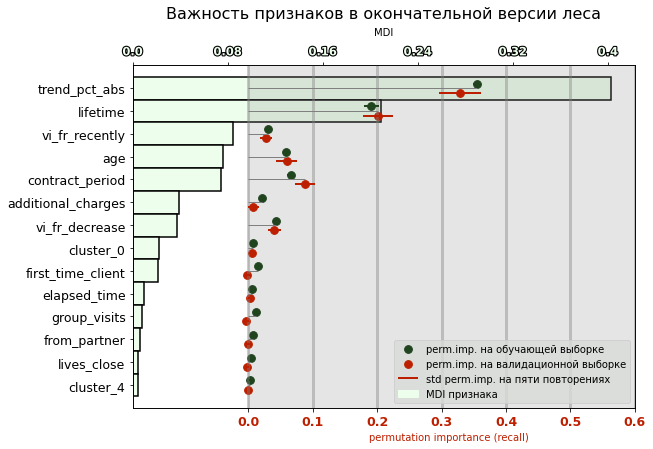

In [48]:
forest_mod2 = RandomForestClassifier(random_state = 0, n_estimators = 170, min_samples_split = 9, max_depth = 11)
X_train, X_test, y_train, y_test = train_test_split(X_for, y, test_size = 0.2, random_state = 0, stratify = y)
forest_mod2.fit(X_train, y_train)
probabilities = forest_mod2.predict_proba(X_test)[:, 1]
draw_roc(y_test, probabilities, title = 'Случайный лес: ROC-кривая')
print()
features_importance(forest_mod2, 'forest', 'Важность признаков в окончательной версии леса', 
                    X_for, y, scoring = 'recall')

В целом, мы перебороли переобученность леса. Хотя чуть выше кросс-валидация показала, что не совсем - вероятности для обучающей выборки лес предсказывает лучше, чем для тестовой. 

По ROC-кривой видно: если при вероятности оттока большей или равной 0.3406 мы будем предсказывать отток, то будем угадывать 96-97 из 100 клиентов, которые в скором времени перестанут посещать спортзал. Примерно 15 из 100 из наших предсказаний будут ошибочными - в этих случаях не случится оттока там, где мы его предсказали.

<a id='target7'></a> 
## Визуализация ошибок
[// вернуться к началу](#target100) 

Если выяснится, что у ошибок есть общие черты, то возможно снизить FPR/TPR, изменив соответствующие признаки или повлияв на их важность для модели. Визуализируем распределение ошибок для наиболее важных признаков двух моделей.

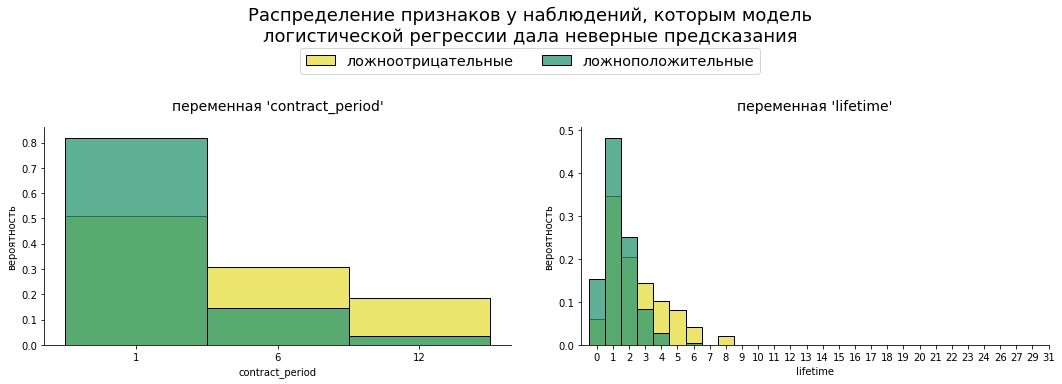

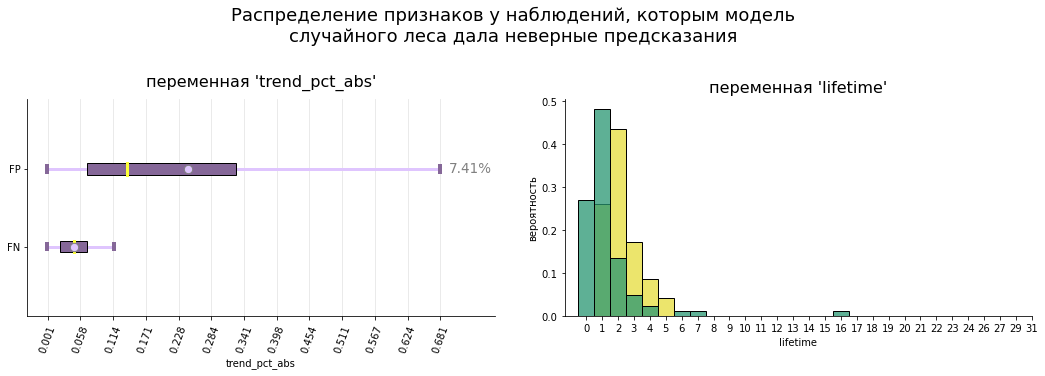

In [49]:
df['probability_logreg'] = lin_mod.predict_proba(X_lin)[:, 1]
df['probability_forest'] = forest_mod2.predict_proba(X_for)[:, 1]

err_logreg = df[ ((df.probability_logreg >= 0.2011) & (df.churn != 1)) | 
                 ((df.probability_logreg < 0.2011) & (df.churn != 0)) ].copy()
err_forest = df[ ((df.probability_forest >= 0.3406) & (df.churn != 1)) | 
                 ((df.probability_forest < 0.3406) & (df.churn != 0)) ].copy()

err_logreg['err_type'] = err_logreg.churn.apply(lambda x: 'FP' if x == 0 else 'FN')
err_forest['err_type'] = err_forest.churn.apply(lambda x: 'FP' if x == 0 else 'FN')

fig = plt.figure(figsize = (18, 4))
fig.suptitle("Распределение признаков у наблюдений, которым модель\n"
             "логистической регрессии дала неверные предсказания", 
             fontsize = 18, y = 1.3)
grid = fig.add_gridspec(1, 2, wspace = 0.15)
fig.add_subplot(grid[0, 0]); fig.add_subplot(grid[0, 1])
categorical_cols = ['contract_period', 'lifetime']
slice_churn = err_logreg[ err_logreg.err_type == 'FP' ]
slice_stay = err_logreg[ err_logreg.err_type == 'FN' ]

for col, ax in zip(categorical_cols, fig.axes):
    mapper = {}
    reverse_mapper = {}
    for i, x in enumerate(np.sort(df[col].unique()), 1):
        mapper.update({x: i})
        reverse_mapper.update({i: x})
    churn_temp = slice_churn[col].copy().map(mapper)
    stay_temp = slice_stay[col].copy().map(mapper)
    if col == categorical_cols[0]:
        labels = ['ложноотрицательные', 'ложноположительные']
    else:
        labels = [None, None]
    sns.histplot(data = stay_temp.reset_index(), x = col, stat = 'probability', label = labels[0],
                 discrete = True, color = '#e6dd3b', ax = ax)
    sns.histplot(data = churn_temp.reset_index(), x = col, stat = 'probability', label = labels[1],
                 discrete = True, color = '#289672', ax = ax)
    ax.set(xticks = list(mapper.values()), xticklabels = [reverse_mapper[val] for val in mapper.values()],
           ylabel = 'вероятность')
    ax.set_title(f"переменная '{col}'", y = 1.05, fontsize = 14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
fig.legend(loc = 'upper center', ncol = 2, fontsize = 'x-large', bbox_to_anchor = (0.5, 1.18))
display(fig)
plt.close(fig)
print()

fig = plt.figure(figsize = (18, 4))
fig.suptitle("Распределение признаков у наблюдений, которым модель"
             "\nслучайного леса дала неверные предсказания", 
             fontsize = 18, y = 1.2)
grid = fig.add_gridspec(1, 2, wspace = 0.15)

ax_trend = fig.add_subplot(grid[0, 0])
ax_life = fig.add_subplot(grid[0, 1])

boxplot_sequence(err_forest, 'err_type', 'trend_pct_abs', x_dec = 3, 
                 title = "переменная 'trend_pct_abs'", ax = ax_trend)

slice_churn = err_forest[ err_forest.err_type == 'FP' ]
slice_stay = err_forest[ err_forest.err_type == 'FN' ]
mapper = {}
reverse_mapper = {}
for i, x in enumerate(np.sort(df['lifetime'].unique()), 1):
    mapper.update({x: i})
    reverse_mapper.update({i: x})
churn_temp = slice_churn['lifetime'].copy().map(mapper)
stay_temp = slice_stay['lifetime'].copy().map(mapper)
sns.histplot(data = stay_temp.reset_index(), x = col, stat = 'probability',
             discrete = True, color = '#e6dd3b', ax = ax_life)
sns.histplot(data = churn_temp.reset_index(), x = col, stat = 'probability',
             discrete = True, color = '#289672', ax = ax_life)
ax_life.set(xticks = list(mapper.values()), xticklabels = [reverse_mapper[val] for val in mapper.values()],
       ylabel = 'вероятность')
ax_life.set_title("переменная 'lifetime'", y = 1, fontsize = 16)

for ax in fig.axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

display(fig)
plt.close(fig)

Кажется, что обе модели, давая предсказания, довольно точно воспроизвели распределение истинных '0' и '1'. Но это не точно. Было бы хорошо отразить на одном графике распределение ошибочных и истинных предсказаний по всем признакам (вместо того, чтобы рисовать по отдельности графики для переменных, которые кажутся наиболее важными, и потом угадывать, насколько точно предсказанные распределения оовпадают с истинными).

In [50]:
def classification_errors(X, y, probabilities, threshold_to_1 = 0.5, title = '', 
                          return_fig = False, drop_features = [], annotate_means = None):
    X = X.copy()
    X['prob'] = probabilities
    X['target'] = y
    
    err_df = X[ ((X.prob >= threshold_to_1) & (X.target != 1)) | 
                ((X.prob < threshold_to_1) & (X.target != 0)) ].copy()
    err_df['err_type'] = err_df.target.apply(lambda x: 'FP' if x == 0 else 'FN')

    all_who_stayed = X[ X.target == 0 ].describe().loc['mean', :]
    all_who_stayed_std = X[ X.target == 0 ].describe().loc['std', :]
    all_who_dropped = X[ X.target == 1 ].describe().loc['mean', :]
    all_who_dropped_std = X[ X.target == 1 ].describe().loc['std', :]
    fp = err_df[ err_df.err_type == 'FP' ].describe().loc['mean', :]
    fp_std = err_df[ err_df.err_type == 'FP' ].describe().loc['std', :]
    fp_cnt = err_df[ err_df.err_type == 'FP' ].describe().loc['count', :]
    fn = err_df[ err_df.err_type == 'FN' ].describe().loc['mean', :]
    fn_std = err_df[ err_df.err_type == 'FN' ].describe().loc['std', :]
    fn_cnt = err_df[ err_df.err_type == 'FN' ].describe().loc['count', :]

    errors = pd.concat([all_who_stayed, all_who_stayed_std, all_who_dropped, all_who_dropped_std, 
                        fp, fp_std, fn, fn_std, fp_cnt, fn_cnt], axis = 1)
    errors.columns = ['stayed', 'stayed_std', 'dropped', 'dropped_std', 'FP', 'FP_std', 'FN', 'FN_std', 
                      'FP_cnt', 'FN_cnt']
    for col in ['FP', 'FN']:
        errors[f'{col}_x1'] = errors[col].sub(errors[f'{col}_std'])
        errors[f'{col}_x2'] = errors[col].add(errors[f'{col}_std'])
        errors[f'{col}_x1'] = errors[col].sub(errors[f'{col}_std'])
        errors[f'{col}_x2'] = errors[col].add(errors[f'{col}_std'])

    drop_features.extend(['target', 'prob'])
    errors.drop(drop_features, axis = 0, inplace = True)
    errors['end_point'] = errors[['stayed', 'dropped']].max(axis = 1)
    errors['end_point_label'] = errors.apply(lambda row: 0 if (row['end_point'] == row['stayed']) else 1, axis = 1)
    errors['start_point'] = errors[['stayed', 'dropped']].min(axis = 1)
    errors['start_point_label'] = errors.apply(lambda row: 0 if (row['start_point'] == row['stayed']) else 1, 
                                               axis = 1)
    s_std = (lambda row: (row['start_point'] - row['stayed_std']) if (row['start_point_label'] == 0) 
                          else (row['start_point'] - row['dropped_std']))
    e_std = (lambda row: (row['end_point'] + row['stayed_std']) if (row['end_point_label'] == 0) 
                          else (row['end_point'] + row['dropped_std']))
    errors['start_std'] = errors.apply(s_std, axis = 1)
    errors['end_std'] = errors.apply(e_std, axis = 1)

    def min_max_scaling(row):
        denominator = row.end_point - row.start_point
        values = (row.loc[['start_std', 'FP', 'FP_x1', 'FP_x2', 'FN', 'FN_x1', 'FN_x2', 'end_std']] 
                  .apply(lambda x: (x - row.start_point) / denominator).values)
        return values
    
    errors['coordinates'] = errors.apply(min_max_scaling, axis = 1)
    errors['min_coord'] = errors['coordinates'].apply(lambda cell: cell.min())
    errors['max_coord'] = errors['coordinates'].apply(lambda cell: cell.max())
    errors['start_std_coord'] = errors['coordinates'].apply(lambda cell: cell[0])
    errors['FP_coord'] = errors['coordinates'].apply(lambda cell: cell[1])
    errors['FP_x1_coord'] = errors['coordinates'].apply(lambda cell: cell[2])
    errors['FP_x2_coord'] = errors['coordinates'].apply(lambda cell: cell[3])
    errors['FN_coord'] = errors['coordinates'].apply(lambda cell: cell[4])
    errors['FN_x1_coord'] = errors['coordinates'].apply(lambda cell: cell[5])
    errors['FN_x2_coord'] = errors['coordinates'].apply(lambda cell: cell[6])
    errors['end_std_coord'] = errors['coordinates'].apply(lambda cell: cell[7])    
    
    colormap = {0: '#1597bb', 1: '#7b113a'}
    xlim = (errors.min_coord.min(), errors.max_coord.max())
    xlim_shift = (xlim[1] - xlim[0]) * 0.03
    yticks = np.arange(errors.shape[0])
    xticks = np.linspace(xlim[0], xlim[1], 10).round(2)
    xticks = xticks[ (xticks > 1.5) | (xticks < -1.5) ]
    xticks = sorted([0, 1] + list(xticks))
    xticklabels = ['0\nменьшее\nсреднее' if x == 0 else x for x in xticks]
    xticklabels = ['1\nбольшее\nсреднее' if x == 1 else x for x in xticklabels]
    
    fig, ax = plt.subplots(figsize = (18, 0.9 * errors.shape[0]))
    ax.set_title(title, y = 1.03, fontsize = 22)
    ax.set(xlim = (xlim[0] - xlim_shift, xlim[1] + xlim_shift), yticks = yticks, ylim = (-1, errors.shape[0] + 1.5),
           xticks = xticks)
    ax.set_xlabel('нормализованные значения переменных', fontsize = 13)
    ax.set_yticklabels(errors.index, rotation = 0, fontsize = 14)
    ax.set_xticklabels(xticklabels, fontsize = 14)
    ax.grid(b = True, axis = 'y')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.vlines(x = [0, 1], ymin = -0.5, ymax = errors.shape[0] - 0.5, color = 'black')
    ax.scatter(x = errors['start_std_coord'], y = yticks, marker = '|', s = 5 * errors.shape[0], 
               color = errors['start_point_label'].map(colormap), linewidth = 5)
    ax.scatter(x = errors['end_std_coord'], y = yticks, marker = '|', s = 5 * errors.shape[0], 
               color = errors['end_point_label'].map(colormap), linewidth = 5)
    ax.hlines(y = yticks, xmin = errors['start_std_coord'], xmax = 0, linestyles = 'solid', 
              color = errors['start_point_label'].map(colormap), linewidth = 5)
    ax.hlines(y = yticks, xmin = 1, xmax = errors['end_std_coord'], linestyles = 'solid', 
              color = errors['end_point_label'].map(colormap), linewidth = 5)
    ax.scatter(x = errors['FN_coord'], y = yticks + 0.2, marker = 'o', s = 5.5 * errors.shape[0], color = colormap[0],
               zorder = 1)
    ax.hlines(y = yticks + 0.2, xmin = errors['FN_x1_coord'], xmax = errors['FN_x2_coord'], linestyles = 'solid', 
              color = colormap[0], alpha = 0.8)
    ax.scatter(x = errors['FP_coord'], y = yticks - 0.2, marker = 'o', s = 5.5 * errors.shape[0], color = colormap[1],
               zorder = 1)
    ax.hlines(y = yticks - 0.2, xmin = errors['FP_x1_coord'], xmax = errors['FP_x2_coord'], linestyles = 'solid', 
              color = colormap[1], alpha = 0.8)

    ax.hlines([], [], [], linestyles = 'solid', color = colormap[0], linewidth = 5, 
              label = "std истинных '0' (соединяется с истинным средним)")
    ax.plot([], [], marker = 'o', ms = 0.4 * errors.shape[0], color = colormap[0], ls = '-.', 
            label = 'среднее и std ложноотрицательных (FN) предсказаний')
    ax.hlines([], [], [], linestyles = 'solid', color = colormap[1], linewidth = 5, 
              label = "std истинных '1' (соединяется с истинным средним)")
    ax.plot([], [], marker = 'o', ms = 0.4 * errors.shape[0], color = colormap[1], ls = '-.', 
            label = 'среднее и std ложноположительных (FP) предсказаний')
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    order = [2, 0, 3, 1]
    ax.legend([handles[i] for i in order],[labels[i] for i in order], 
              fontsize = 'x-large', ncol = 2, loc = 'upper center', frameon = False)
    
    if annotate_means or annotate_means == 0:
        if annotate_means == 0:
            errors['start_point'] = errors['start_point'].round(0).astype('int')
            errors['end_point'] = errors['end_point'].round(0).astype('int')
        elif annotate_means > 0:
            errors['start_point'] = errors['start_point'].round(annotate_means)
            errors['end_point'] = errors['end_point'].round(annotate_means)
        for i in yticks: 
            ax.text(s = errors.iloc[i]['start_point'], x = 0 - xlim_shift * 0.3, y = i + 0.07, va = 'bottom', 
                    ha = 'right', fontsize = 13)
            ax.text(s = errors.iloc[i]['end_point'], x = 1 + xlim_shift * 0.3, y = i + 0.07, va = 'bottom', 
                    ha = 'left', fontsize = 13)

    if return_fig:
        return fig
    else:
        display(fig)
        plt.close(fig)

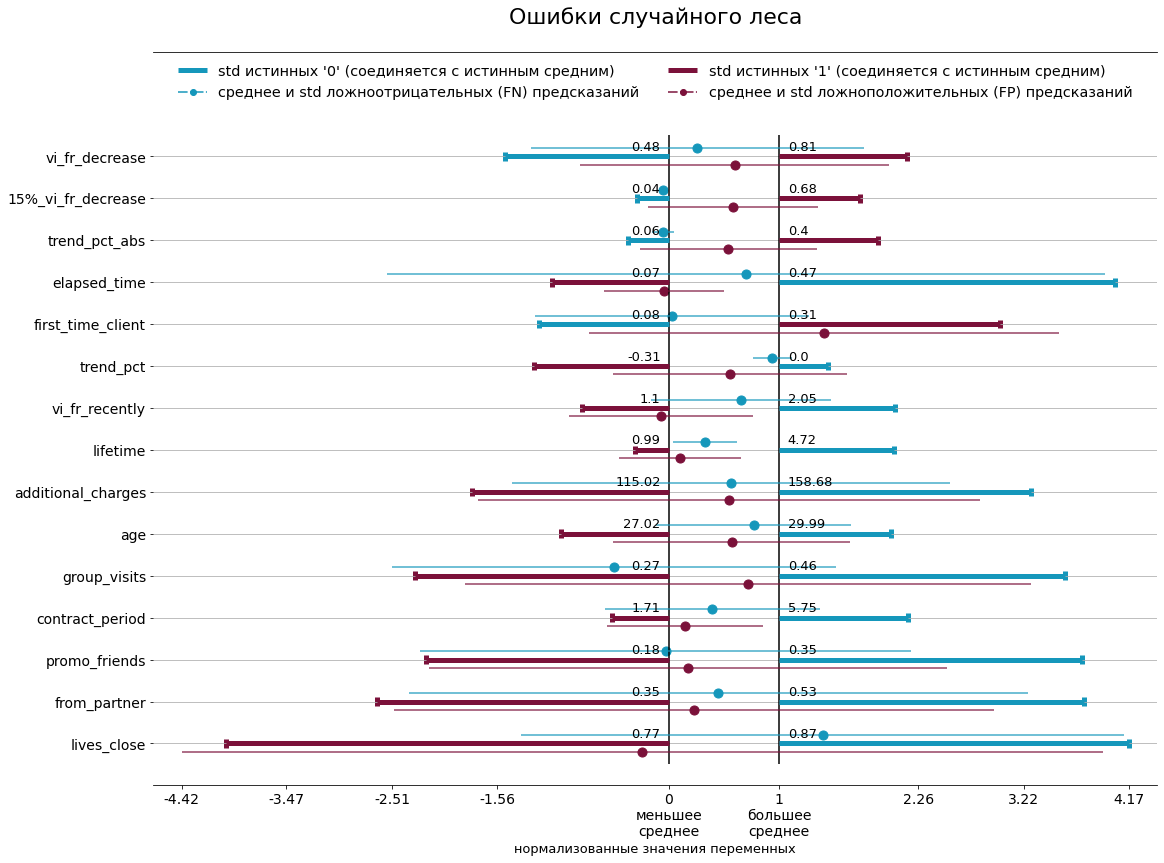

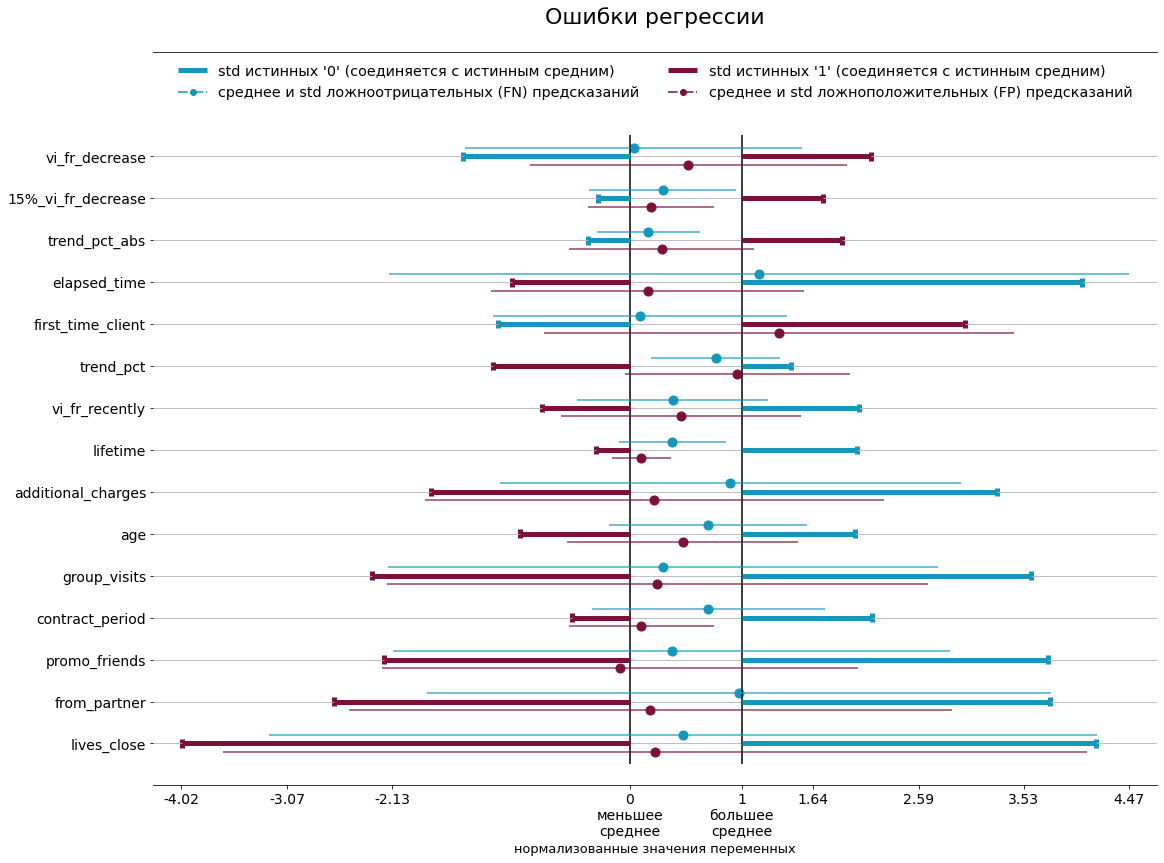

In [51]:
classification_errors(df.drop('churn', axis = 1).iloc[:, :-3], y, forest_mod2.predict_proba(X_for)[:, 1], 
                      threshold_to_1 = 0.3406, title = 'Ошибки случайного леса', annotate_means = 2)
print()
classification_errors(df.drop('churn', axis = 1).iloc[:, :-3], y, lin_mod.predict_proba(X_lin)[:, 1], 
                      threshold_to_1 = 0.2011, title = 'Ошибки регрессии')

Немного о том, куда на графиках смотреть: чем больше распределение False Positive напоминает распределение истинных Positive, и распределение False Negative - истинных Negative, тем сложнее скорректировать вероятности и сделать правильные предсказания, особенно если речь о признаках, имеющих в модели большой вес. Напротив, чем больше распределение тянется к противоположному классу, тем лучше. Нужно обратить внимание, если в границы двух стандартных отклонений не входит истинное среднее предсказанного класса, или если std в "ложноположительной" или в "ложноотрицательной" выборке сильно отличается от соответствующего std в "истинной" выборке. При этом нужно держать в уме, что у небольших выборок распределение стандартной ошибки и дисперсия имеют больший размах, чем в нормальном распределении (а выборки с ошибочными предсказаниями в нашем случае действительно небольшие, хотя меньше тридати наблюдений нет ни в одной). Сама по себе длина std мало о чём говорит - длинная линия может появиться как в том случае, когда истинные средние несильно отличаются, так и в том случае, когда стандартное отклонение на самом деле велико. Но если истинное std в несколько раз короче расстояния между истинными средними, значит, признак должен иметь большой вес в модели (именно это мы видим у признаков 'trend', 'lifetime', '15%_vi_fr_decrease' и отчасти 'contract_period'). 

Что касается значений большинства переменных в ошибочных предсказаниях - то они просто обманчивы. Обманывают не только модель, но и нас. Например, обманчивы значения в переменных 'elapsed_time' и 'trend_pct_abs': 100% ложноотрицательных предсказаний леса - это те клиенты, у которых низкое 'trend_pct_abs' - такое, которое характеризует именно сохранённых, а не выбывших клиентов. К тому же, модель леса сильно полагается на значения 'trend_pct_abs' - обычно они корректируют вероятность в нужную сторону. 

Если мы берёмся за работу над ошибками, то не так много переменных, на которые можно ориентироваться. Лес мог бы исправить часть ошибок, если бы большую важность имели признаки 
- 'group_visits' (клиенты, которым ошибочно предсказано сохранение, посещают групповые занятия реже, чем истинные сохранённые и даже реже, чем истинные выбывшие), 
- 'promo_friends' (то же самое, что с 'group_visits')
- 'lifetime' (у клиентов, которым ошибочно предсказано сохранение, lifetime скорее принадлежит распределению выбывших клиентов) 

А логистическая регрессия:
- 'trend_pct' (среднее значение этого поля у клиентов, которым предсказан отток, примерно равно 0, то есть совпадает со средним у сохранённых клиентов)

Есть ещё простор для улучшения моделей, но довольно ограниченный. Целевая переменная не может зависить исключительно от значений того набора признаков, который у нас в наличии. При обучении модели, предсказывающей поведение человека, равно или поздно наступает момент, когда нужно смириться с исключениями. Это не наш случай, но мы довольно близко подошли к этому (по крайней мере, с этим набором признаков). 

<a id='target99'></a>
## Резюме
[// вернуться к началу](#target100) 

- **EDA**: созданы новые поля 'trend_pct', 'trend_pct_abs', 'first_time_client', '15%_vi_fr_decrease', 'vi_fr_decrease', 'elapsed_time' и 'cluster' (в результате кластеризации). Из этих полей четыре оказались в той или иной степени полезны. Удалены около 80 записей, показавшиеся странными. Выбивающихся из общей массы значений нет, пропусков нет. Из всех имеющихся переменных лишь две никак не характеризуют отток, остальные характеризуют, притом для каждой из них разница между оттоком и удержанием уходит далеко за порог статистической значимости. Благодаря этому даже ненастроенные модели отлично справляются с предсказаниями.


- **Признаки, влияющие на отток**: если клиент получил корпоративную скидку на абонемент ('from_partner') или приглашение от друга ('promo_friends'), то он будет посещать спортзал с большей вероятностью, чем тот, кто этих скидкок не получил. Клиенты, которые ходят на групповые занятия ('group_visits'), выбывают реже тех, кто тренируется самостоятельно. Проживание вдалеке от спортзала ('lives_close') - фактор, негативно влияющий на вероятность оттока. Чаще всего заканчивается оттоком резкое увеличение или резкое уменьшение частоты посещений (переменная 'trend_pct'). Большая часть оттока приходится на клиентов, пришедших в спортзал совсем недавно (переменная 'lifetime') - практиески все тренируются не больше трёх месяцев. Также выбывшие клиенты в средне тратят меньшие суммы денег на дополнительные услуги, моложе на два года и тренируются в два раза реже тех, кто не выбывает. Около 90% выбывших - владельцы месячных абонементов. 


- **Кластеризация**: шесть кластеров - самое лучшее. Стоит отметить, что для всех варинтов кластеризации silhouette низкое - кластеризация не очень естественно ложится на полный набор признаков. 


- **Машинное обучение**: для компании приоритетной метрикой является полнота, то есть способность угадать как можно больше клиентов, которые в скором времени уйдут в отток (минимизация False Negative). Модель случайного леса даёт лучшие показатели: если при вероятности оттока большей или равной 0.3406 мы будем предсказывать отток, то будем угадывать 97 из 100 клиентов, которые в скором времени перестанут посещать спортзал. Примерно 15 из 100 таких предсказаний будут ошибочными - в этих случаях не случится оттока там, где мы его предсказали. Модель логистической регрессии несколько хуже: с ней мы сможем угадывать 94-95 из 100 клиентов, совершая 17-18 ошибок на каждые сто предсказаний оттока. Одно решающее дерево можно настроить так, чтобы угадывать 85 из 100 клиентов, ошибаясь в 21 случае, зато предсказания будут делаться за три шага. 

<a id='target100'></a> 
## Рекоммендации для борьбы с оттоком
[// вернуться к началу](#target100) 

- Продавать абонементы на пол года и на год. Основной отток (около 90%) среди тех, кто владеет месячным абонементом.
- Вовлекать клиентов в приятные коммуникации: будет хорошо, если они начнут посещать группвые занятия или заведут в спортзале знакомства. Если в зале всегда бывают тренера, то стоит придумать формат общения, когда клиенты смогут с ними познакомиться, а тренера - заработать доверие клиентов. 
- Сопровождать новых посетителей (низкий lifetime), или хотя бы тех из них, кто пользуется своим первым абонементом ('first_time_client'). Нужно стремиться к тому, чтобы они чувствовали себя уверенно в спортзале и получали удовлетворение от тренировок.
- Стоит сопровождать и тех, кто за последнее время стал тренироваться намного чаще, чем раньше. Нужно буквально следить за тем, чтобы они себя не травмировали и, если есть возможность, помогать им восстанавливаться (скидки или угощения в фитнесс-баре, рассылка полезных советов и статей про ЗОЖ, подарки от партнёров - саун и массажных салонов). 
- Будет рациональным решением нацелить маркетинговые компании на людей постарше и на корпоративных клиентов.